In [340]:
import lightkurve as lk
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Input, Concatenate, Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Metadata

## Načtení

In [324]:
pos = pd.read_csv("positive.csv")
pos

host  period
0    Kepler-1   2.470
1    Kepler-2   2.200
2    Kepler-3   4.890
3    Kepler-4   3.210
4    Kepler-5   3.580
5    Kepler-6   3.230
6    Kepler-7   4.890
7    Kepler-8   3.522
8   Kepler-11  32.000
9   Kepler-11  22.680
10  Kepler-11  13.020
11  Kepler-12   4.440
12  Kepler-13   1.760
13  Kepler-14   6.790
14  Kepler-15   4.940
15  Kepler-17   1.480
16  Kepler-18   7.650
17  Kepler-18  14.860
18  Kepler-19   9.290
19  Kepler-21   2.790
20  Kepler-23   7.100
21  Kepler-23  15.270

## Seskupení dle systémů

In [325]:
grouped_pos = pos.groupby("host").period.apply(list).to_dict()
grouped_pos

{'Kepler-1': [2.47],
 'Kepler-11': [32.0, 22.68, 13.02],
 'Kepler-12': [4.44],
 'Kepler-13': [1.76],
 'Kepler-14': [6.79],
 'Kepler-15': [4.94],
 'Kepler-17': [1.48],
 'Kepler-18': [7.65, 14.86],
 'Kepler-19': [9.29],
 'Kepler-2': [2.2],
 'Kepler-21': [2.79],
 'Kepler-23': [7.1, 15.27],
 'Kepler-3': [4.89],
 'Kepler-4': [3.21],
 'Kepler-5': [3.58],
 'Kepler-6': [3.23],
 'Kepler-7': [4.89],
 'Kepler-8': [3.522]}

## Doplnění negativních period

In [326]:
grouped = []

for host in grouped_pos:
    periods = grouped_pos[host]
    
    grouped_item = {"host": host, "periods": []}

    for i in range(len(periods)):
        next = periods[i]
        current = {"period": round(next, 3), "planet": 1}

        if i > 0:
            last = periods[i - 1]
            mid = max((next + last) / 2, 0.6 * 1.13)
            grouped_item["periods"] += [{"period": round(mid, 3), "planet": 0}, current]
        else:
            grouped_item["periods"] += [current]

    grouped_item["periods"] += [{"period": round(periods[-1] * 1.67, 3), "planet": 0}]
    grouped.append(grouped_item)

grouped

[{'host': 'Kepler-1',
  'periods': [{'period': 2.47, 'planet': 1}, {'period': 4.125, 'planet': 0}]},
 {'host': 'Kepler-11',
  'periods': [{'period': 32.0, 'planet': 1},
   {'period': 27.34, 'planet': 0},
   {'period': 22.68, 'planet': 1},
   {'period': 17.85, 'planet': 0},
   {'period': 13.02, 'planet': 1},
   {'period': 21.743, 'planet': 0}]},
 {'host': 'Kepler-12',
  'periods': [{'period': 4.44, 'planet': 1}, {'period': 7.415, 'planet': 0}]},
 {'host': 'Kepler-13',
  'periods': [{'period': 1.76, 'planet': 1}, {'period': 2.939, 'planet': 0}]},
 {'host': 'Kepler-14',
  'periods': [{'period': 6.79, 'planet': 1}, {'period': 11.339, 'planet': 0}]},
 {'host': 'Kepler-15',
  'periods': [{'period': 4.94, 'planet': 1}, {'period': 8.25, 'planet': 0}]},
 {'host': 'Kepler-17',
  'periods': [{'period': 1.48, 'planet': 1}, {'period': 2.472, 'planet': 0}]},
 {'host': 'Kepler-18',
  'periods': [{'period': 7.65, 'planet': 1},
   {'period': 11.255, 'planet': 0},
   {'period': 14.86, 'planet': 1},
   {

# Trénovací množina

## Stažení TPS a uložení křivek

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

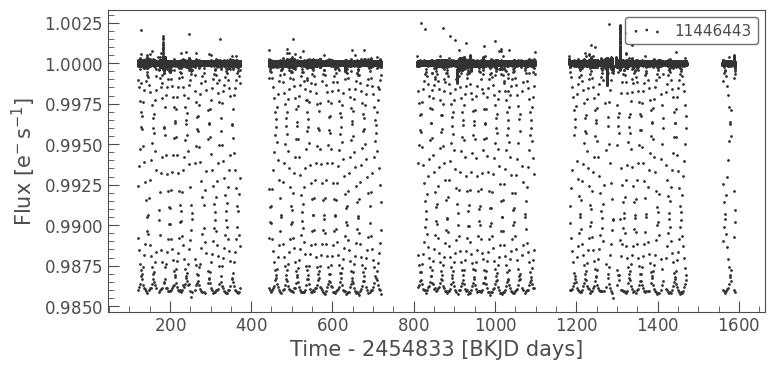

In [327]:
lcs = {}

for item in grouped:
    host, periods = item["host"], item["periods"]
    lc_path = f".cache/lc/{host}.fits"

    try:
        lc = lk.read(lc_path)
    except:
        result = lk.search_targetpixelfile(host, mission="Kepler", exptime="long")
        tps = result.download_all()
        lcc = map(lambda tp: tp.to_lightcurve(aperture_mask=tp.pipeline_mask).flatten(window_length=201), tps)
        lcc = lk.LightCurveCollection(lcc)
        lcc.plot()
        lc = lcc.stitch().remove_outliers(sigma_upper=3, sigma_lower=20)
        lc.to_fits(lc_path)

    lcs[host] = lc

lcs[list(lcs.keys())[0]].scatter()

## Hledání period a sestavení lokálních a globálních pohledů

`period` contains 353700 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.
`period` contains 211791 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.
/home/michal/.local/lib/python3.8/site-packages/lightkurve/lightcurve.py:1772: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
`period` contains 196765 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.
`period` contains 117820 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.
`period` contains 496386 points.Periodogram is l

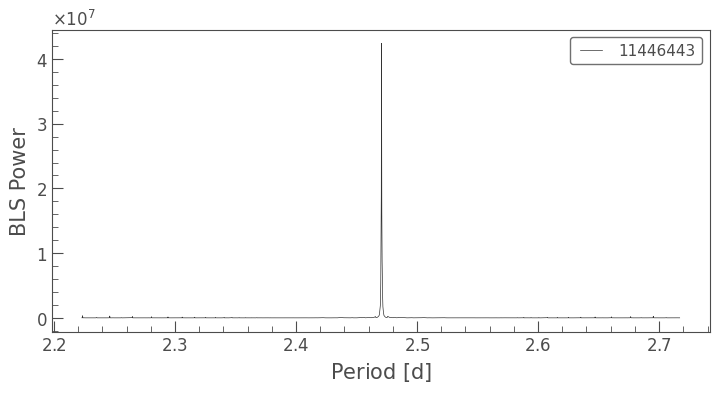

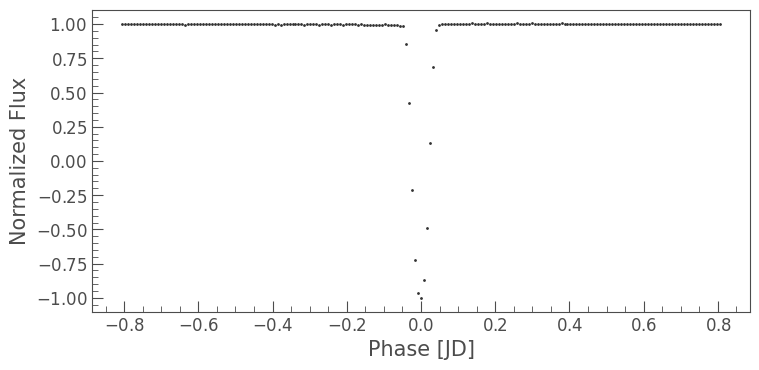

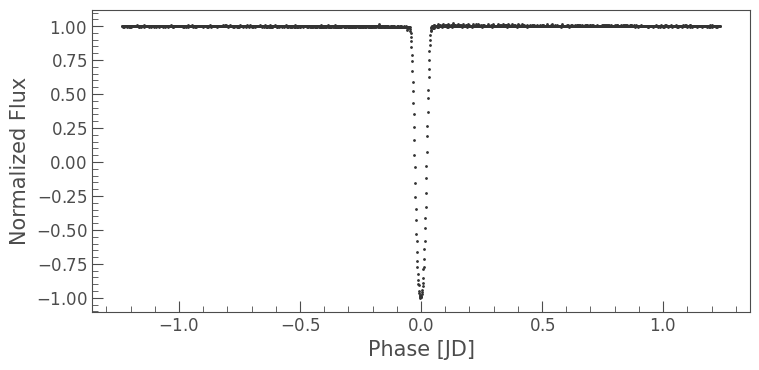

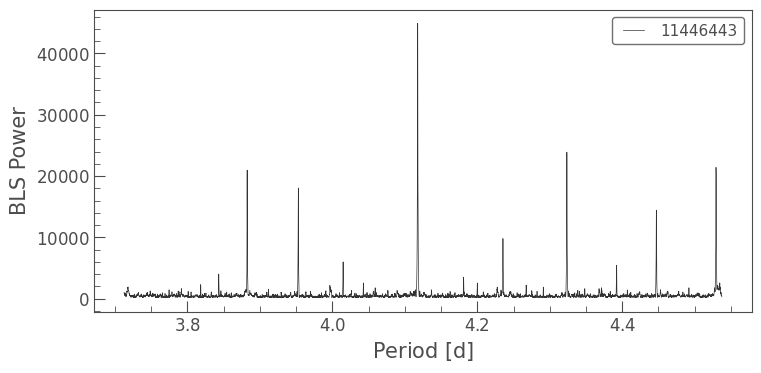

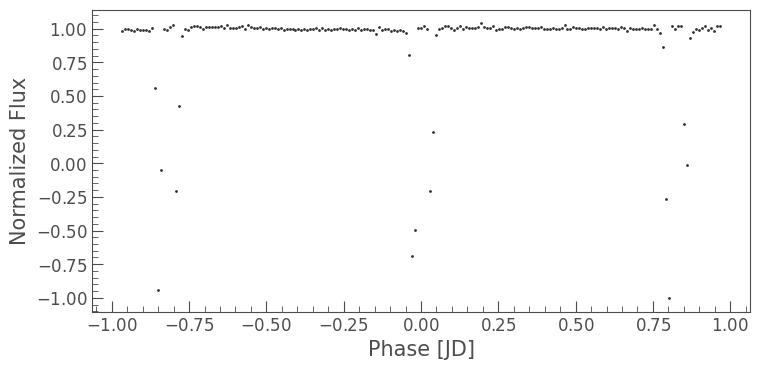

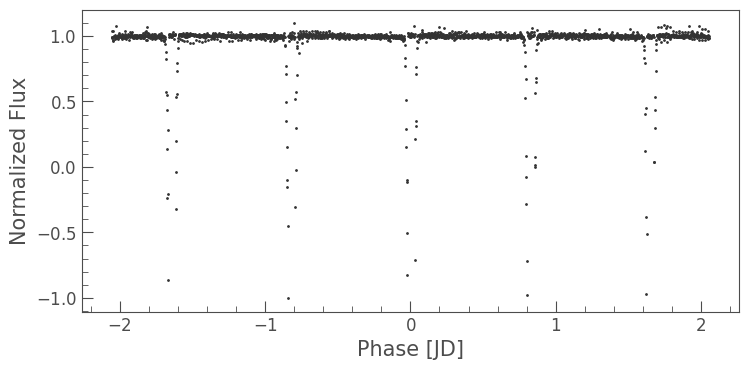

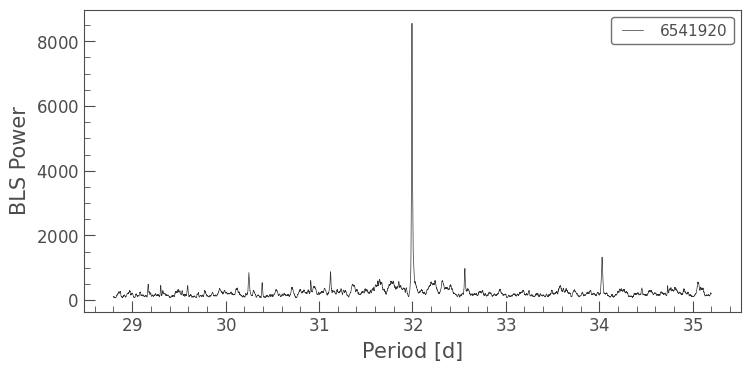

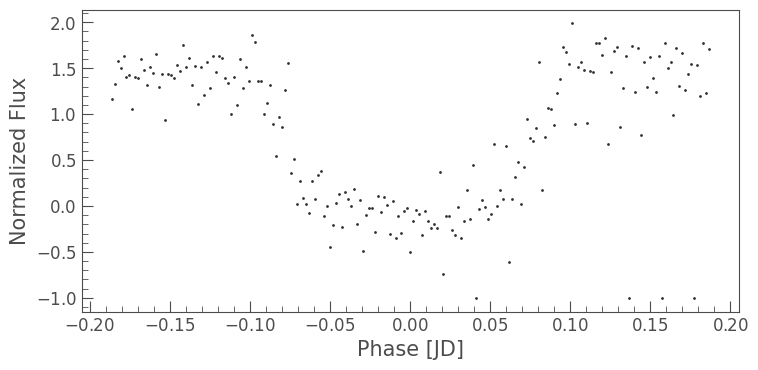

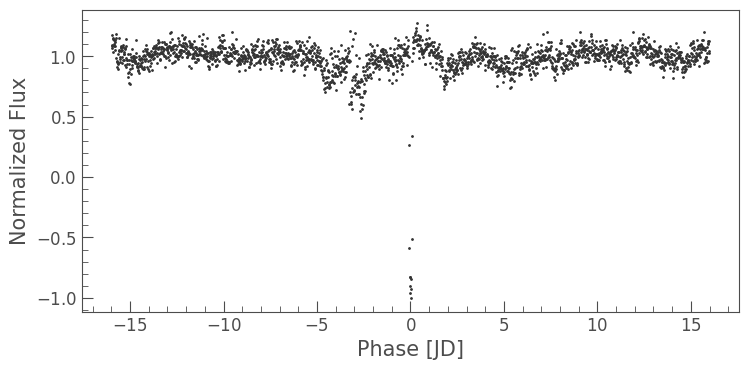

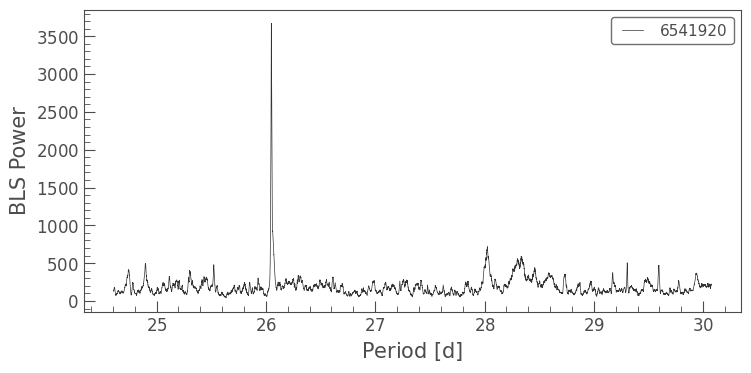

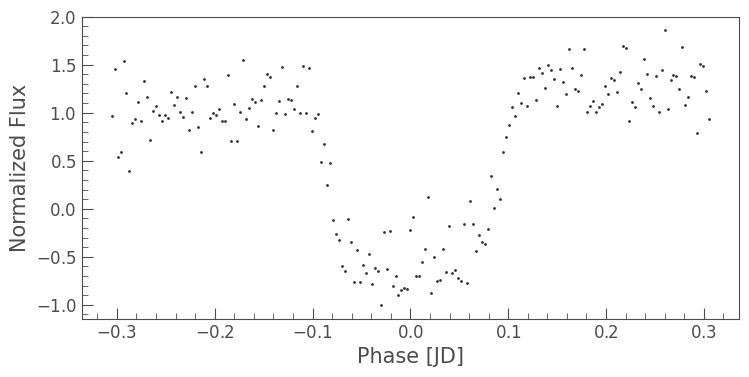

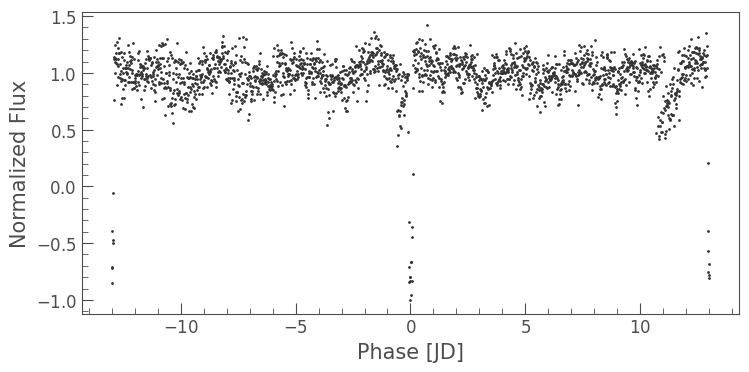

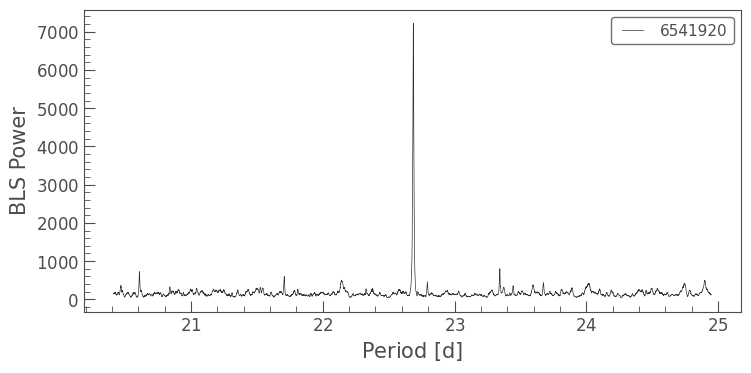

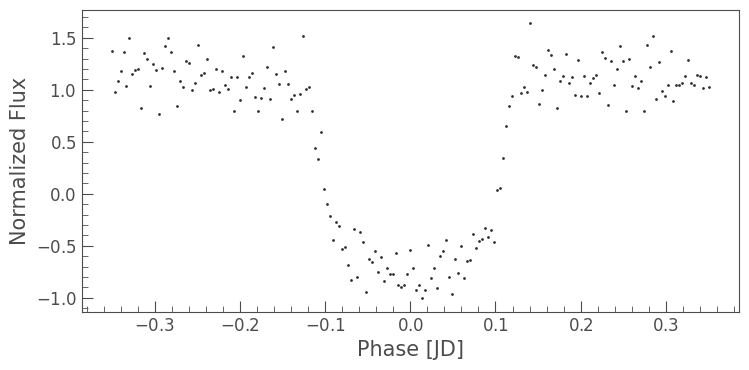

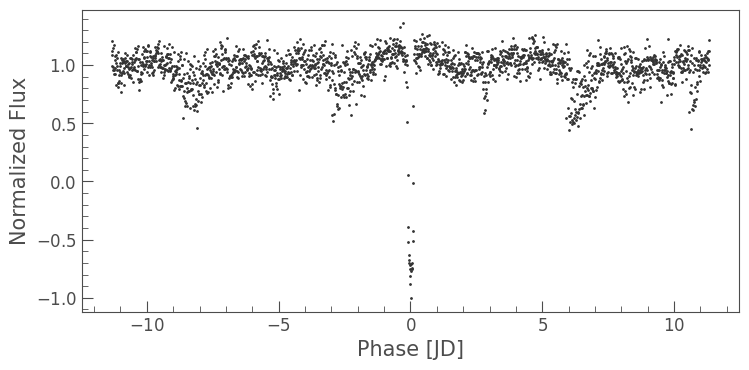

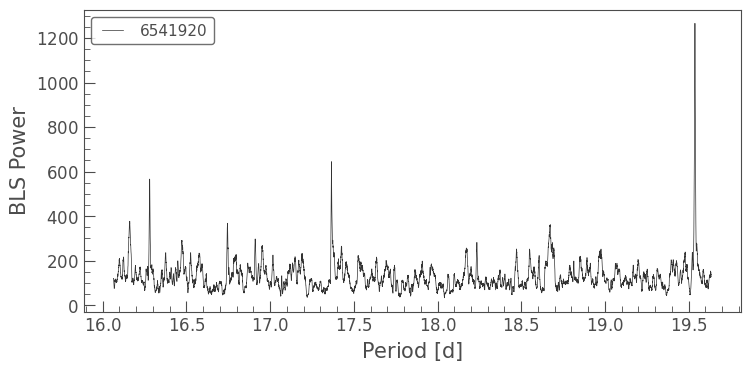

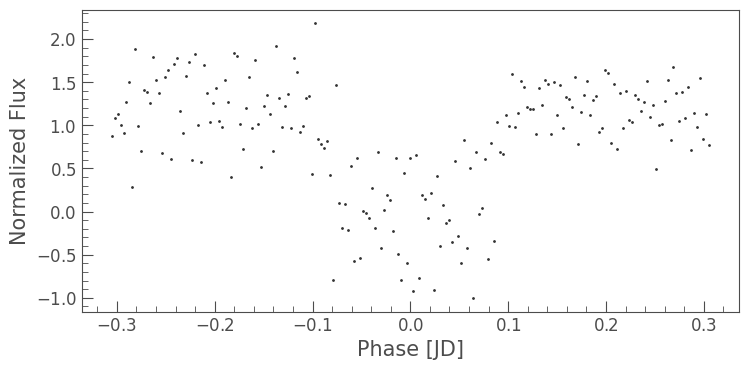

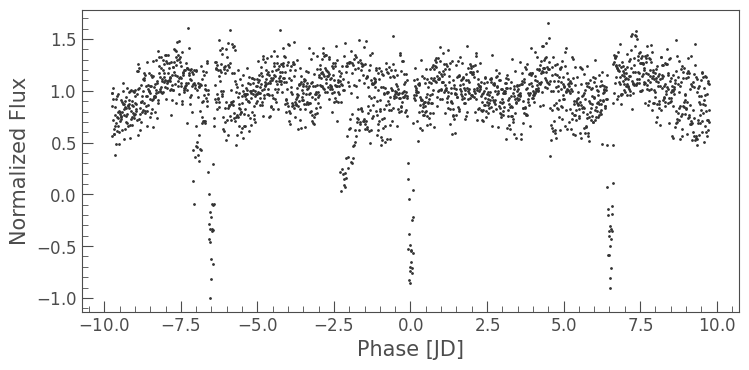

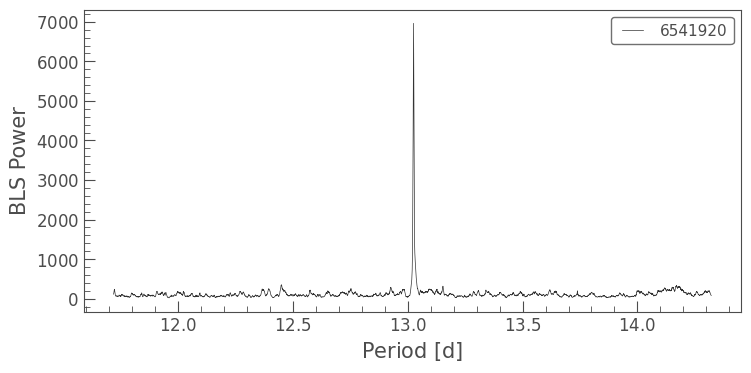

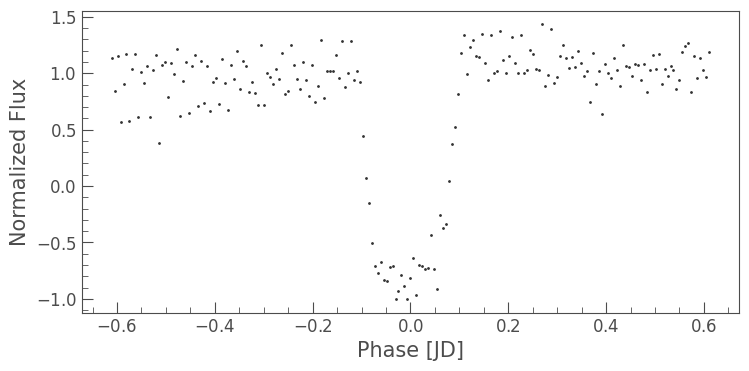

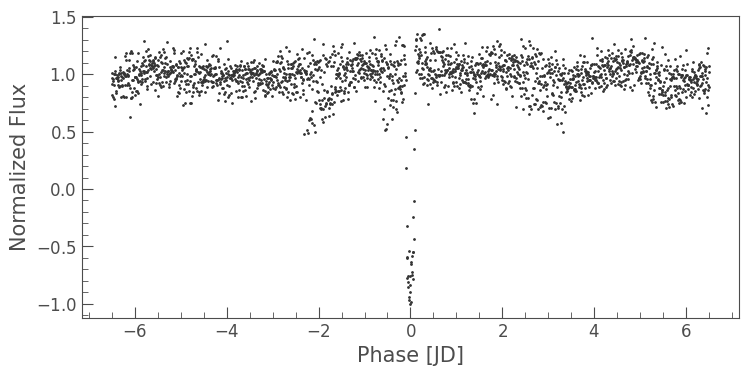

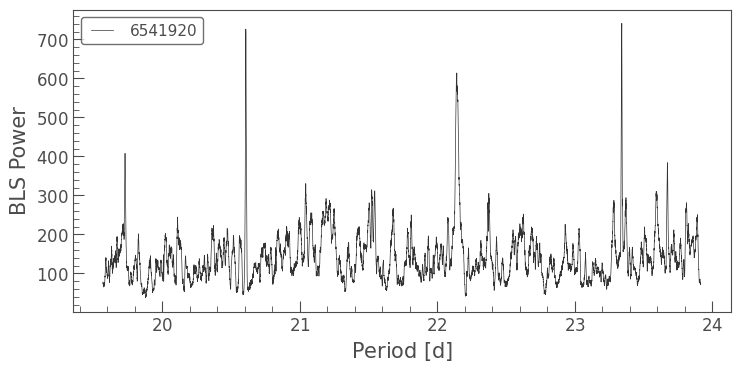

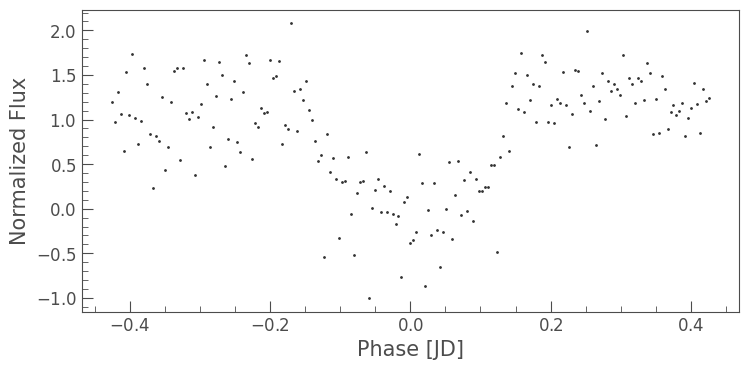

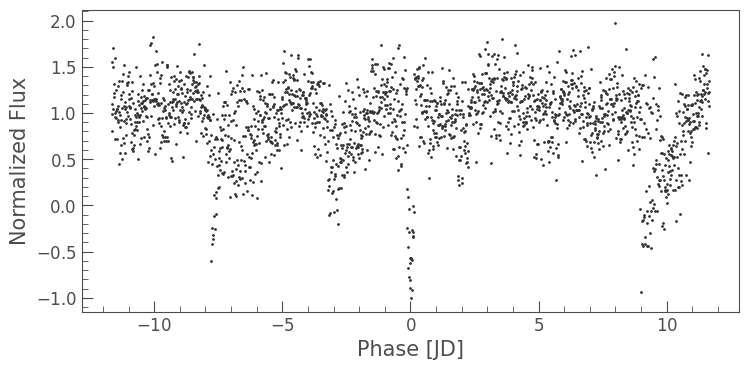

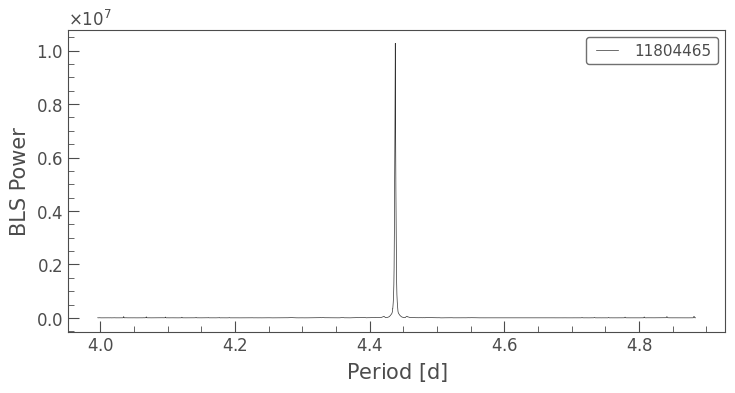

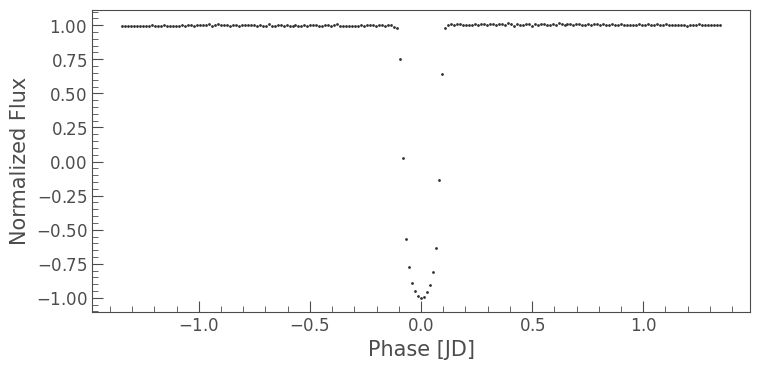

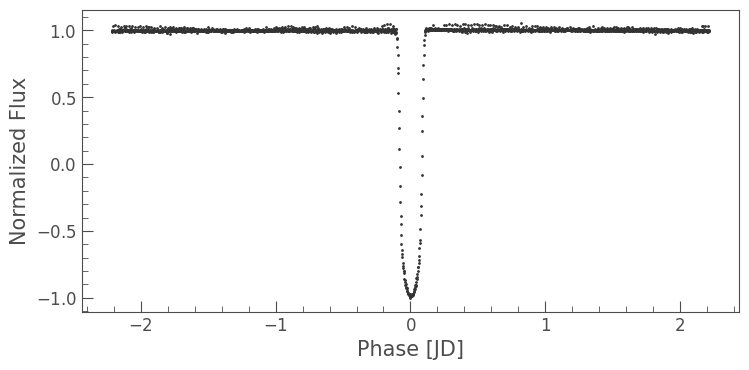

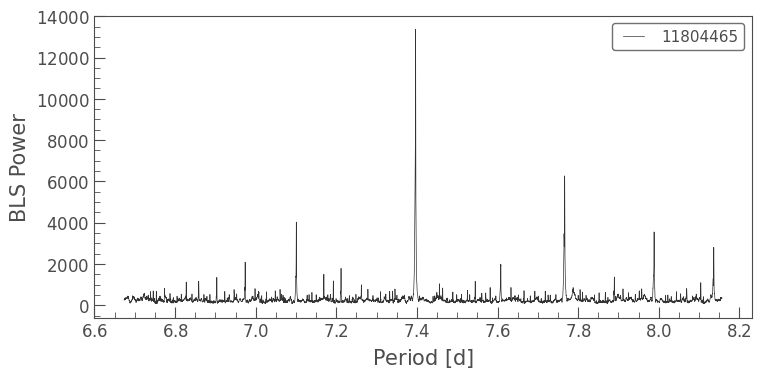

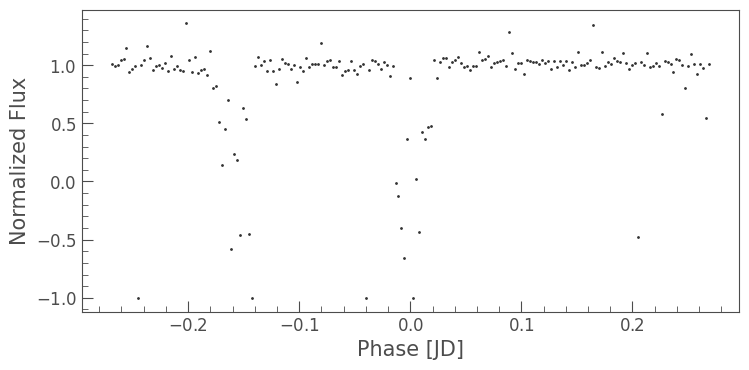

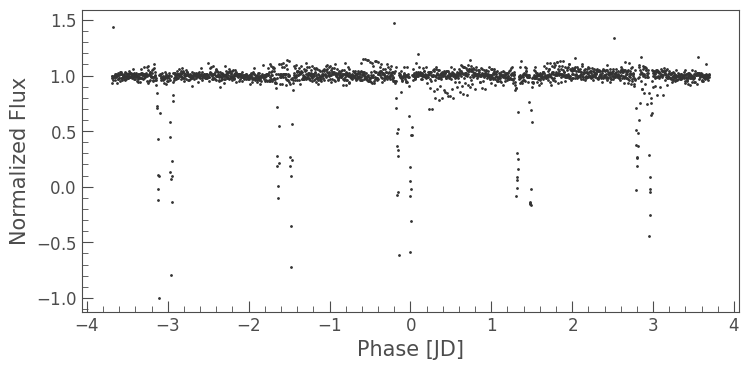

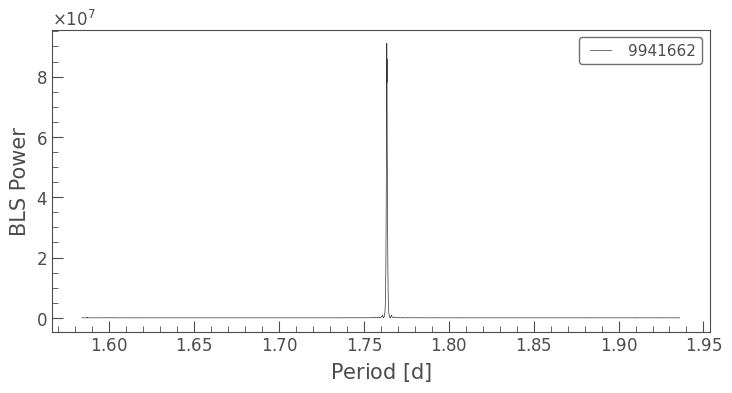

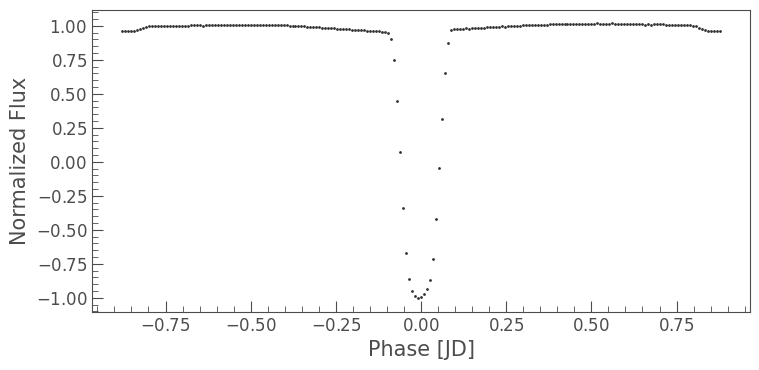

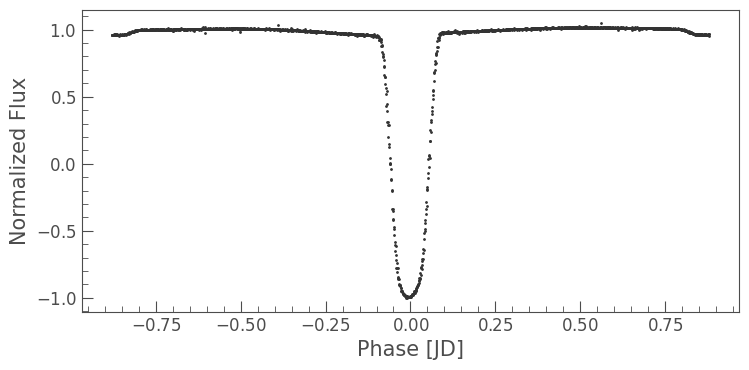

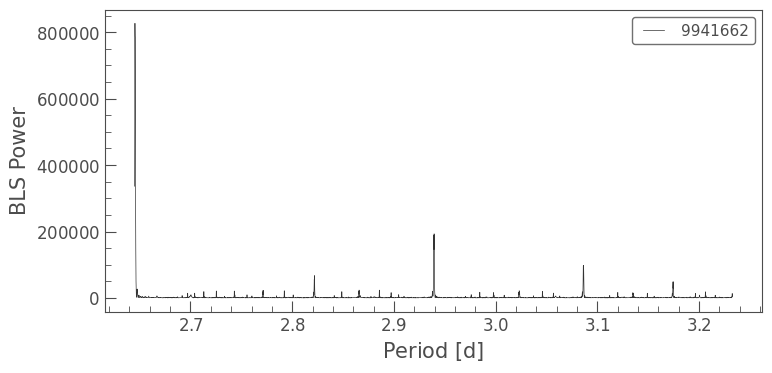

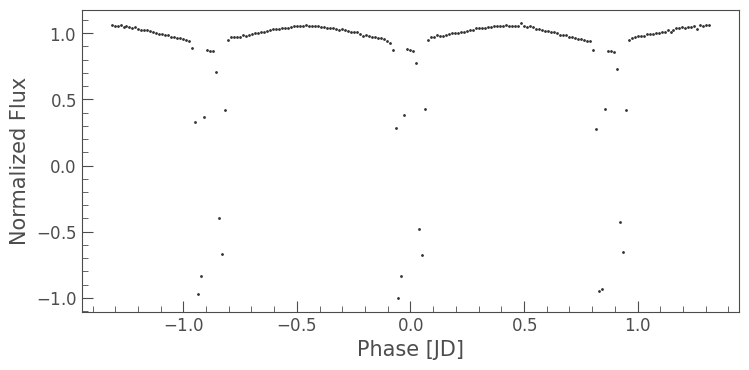

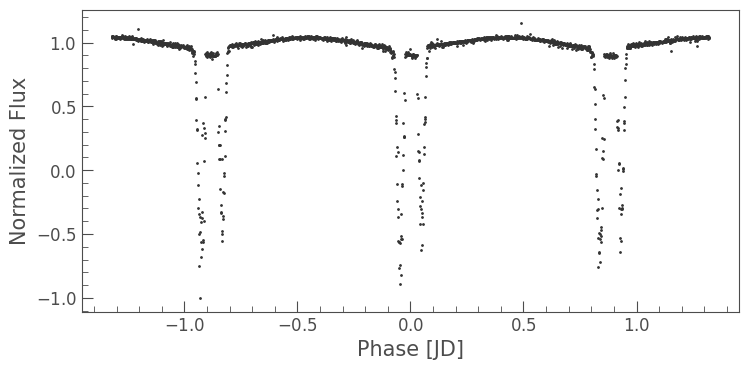

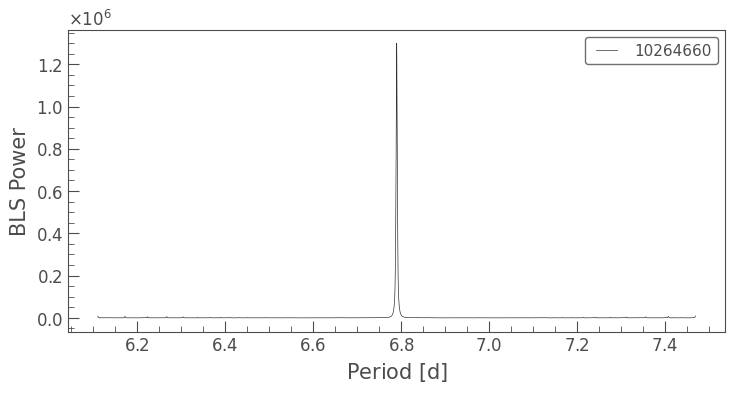

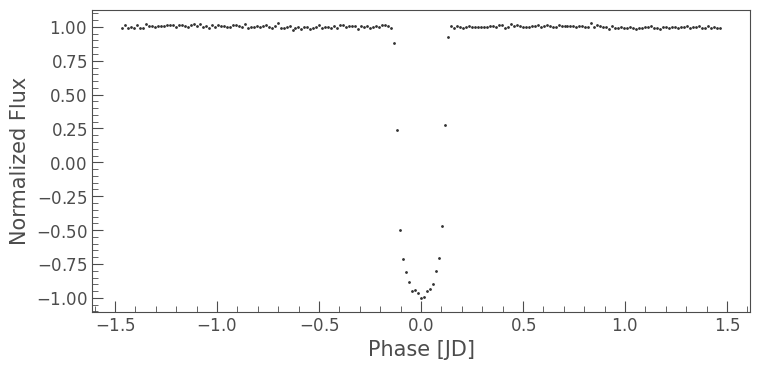

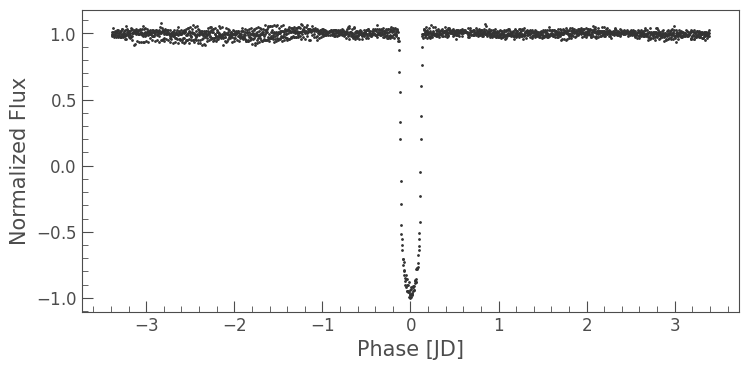

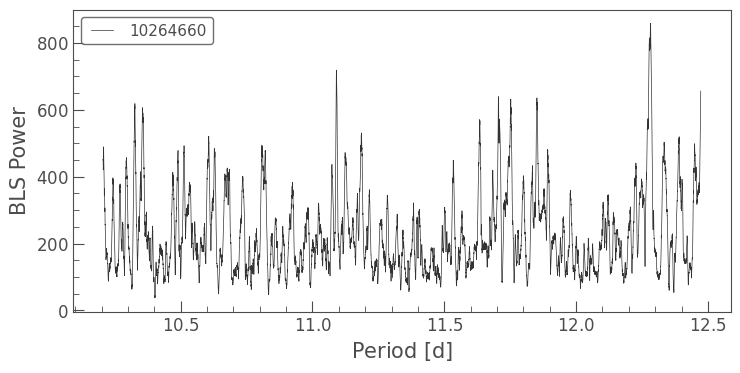

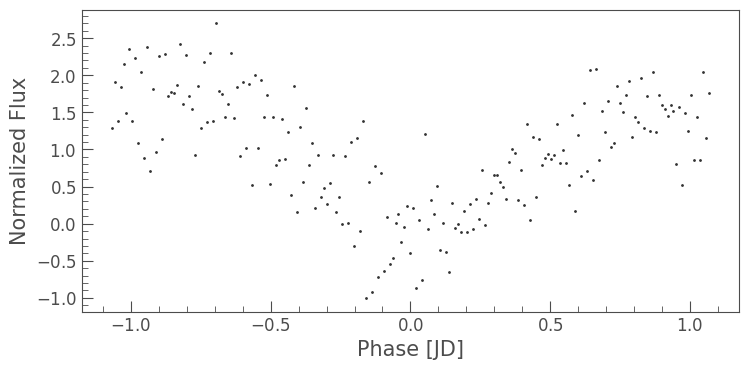

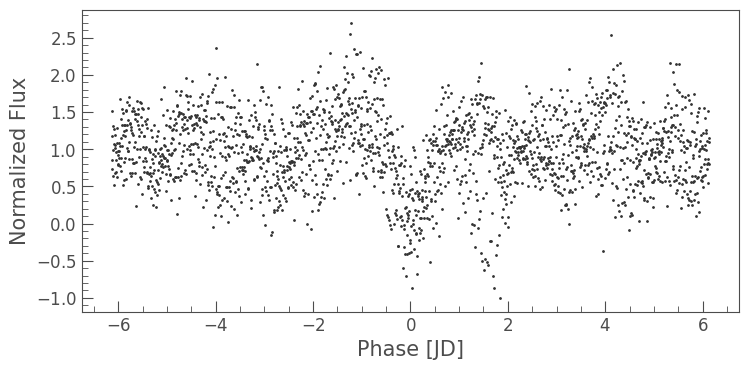

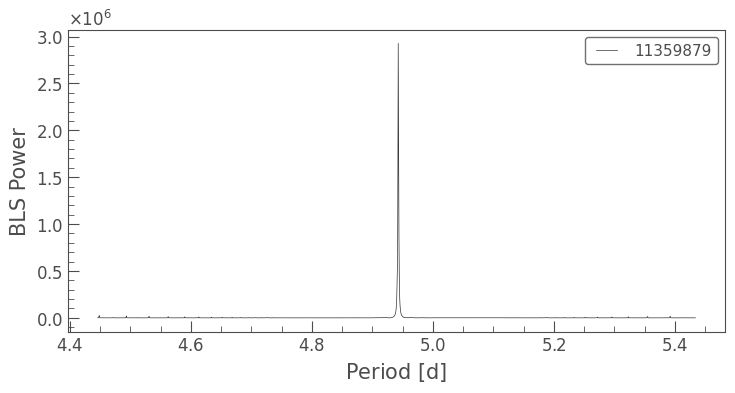

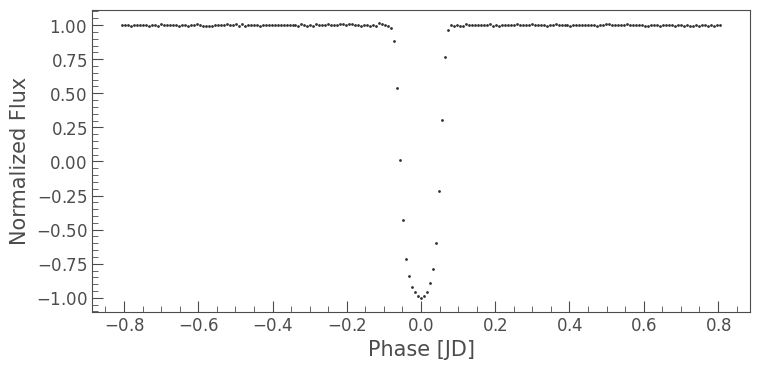

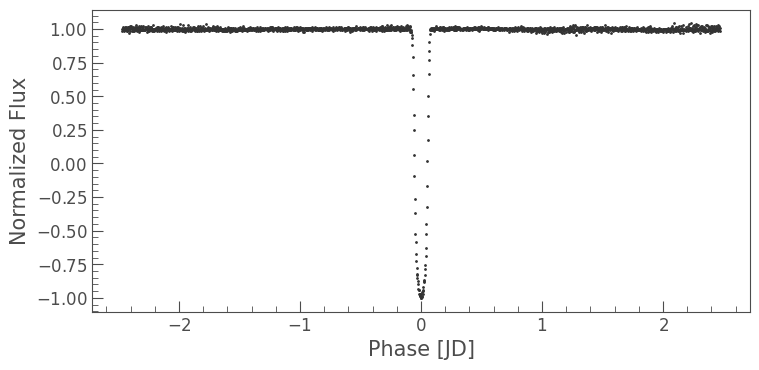

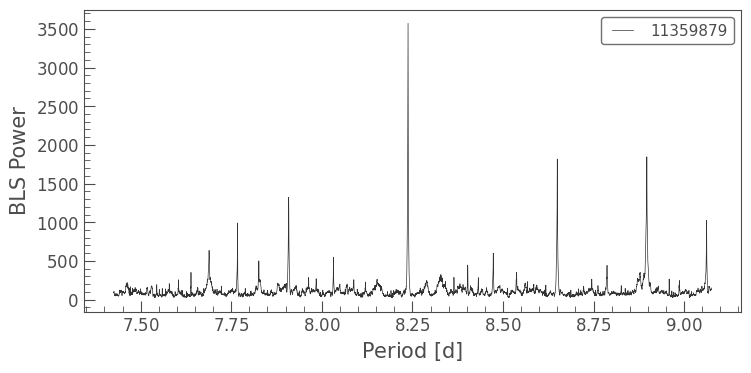

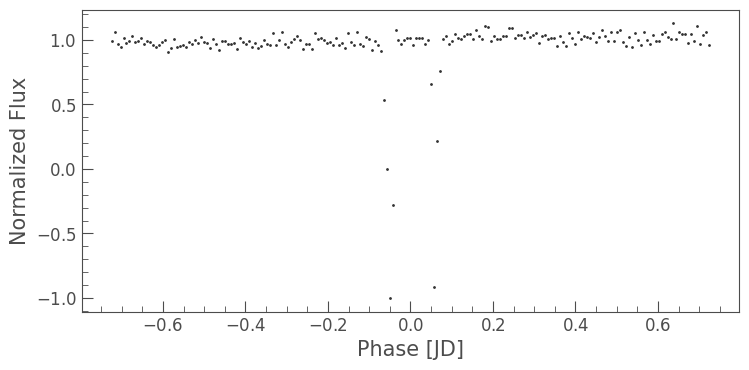

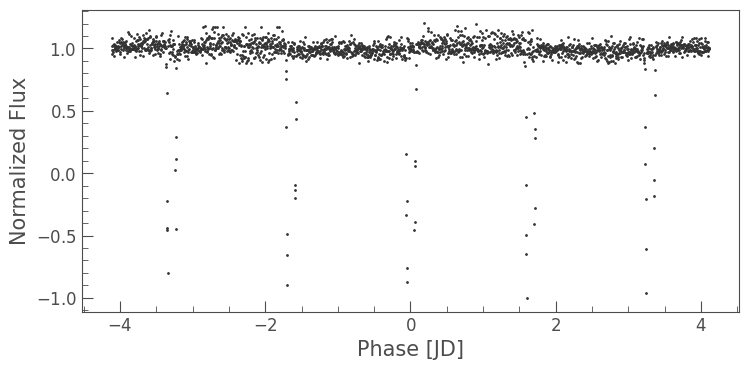

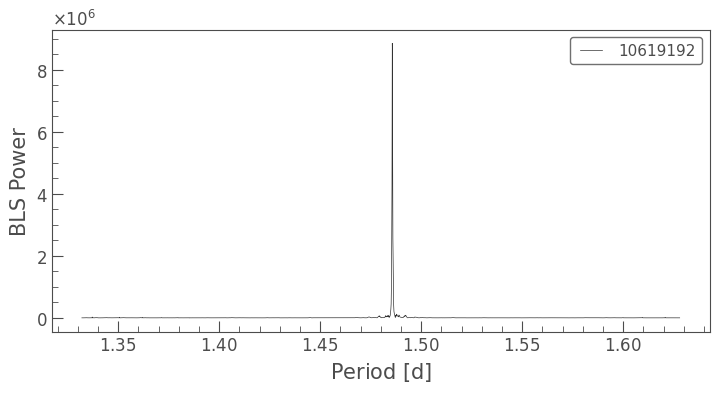

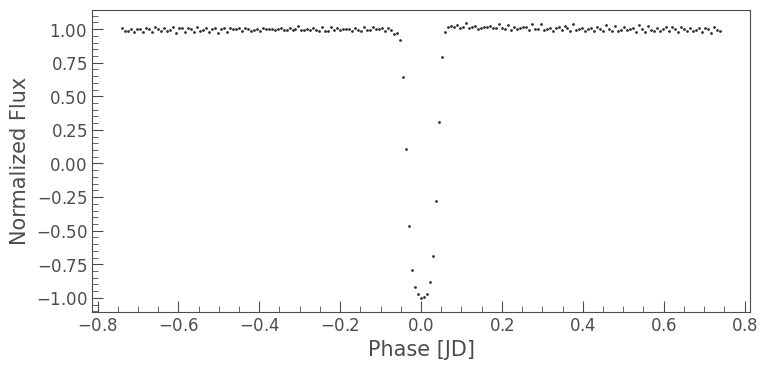

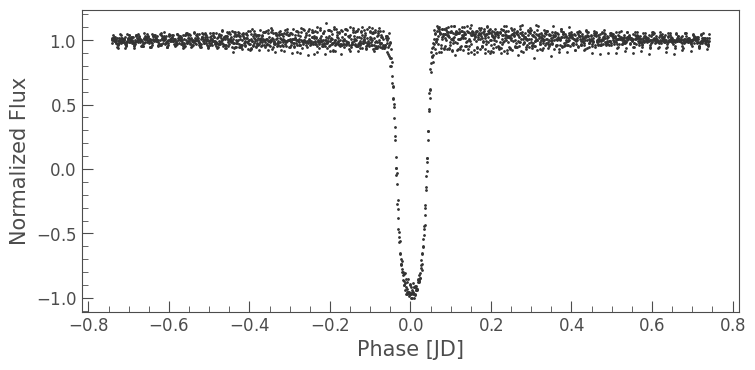

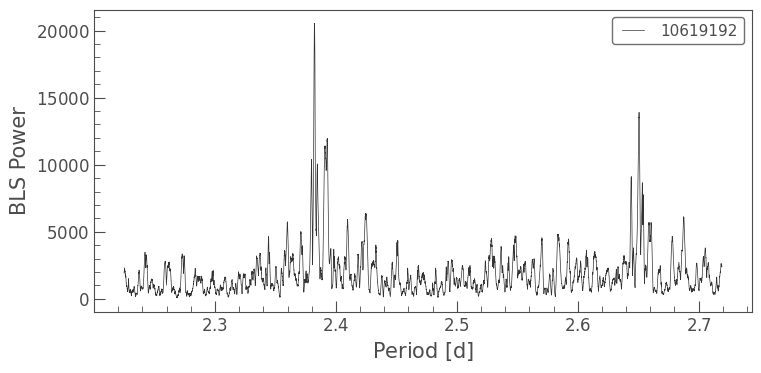

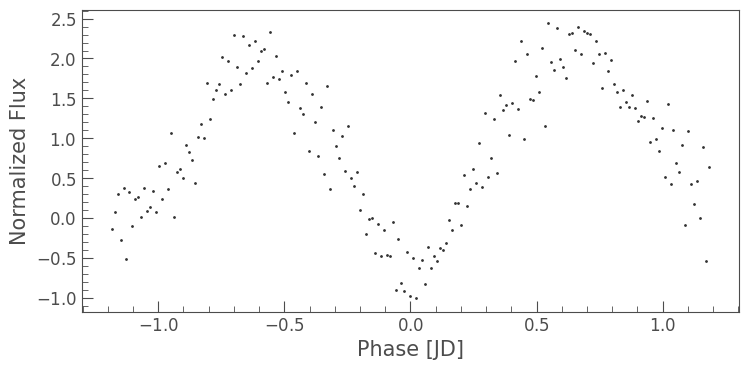

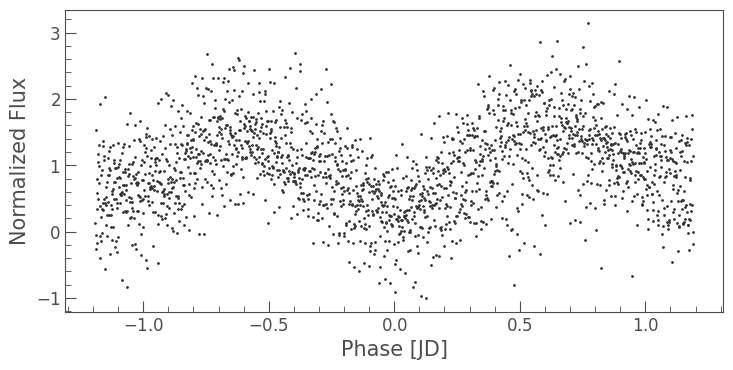

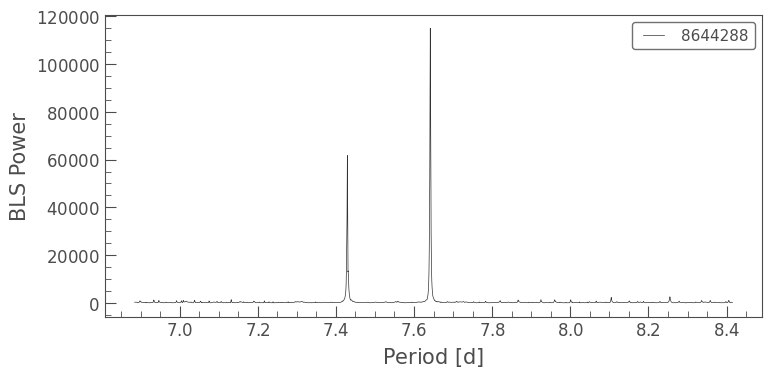

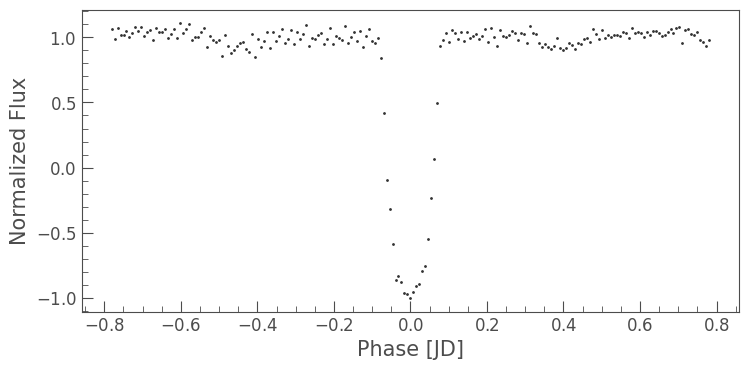

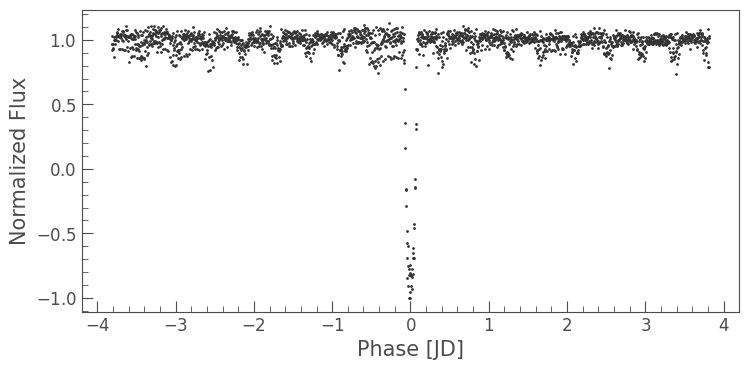

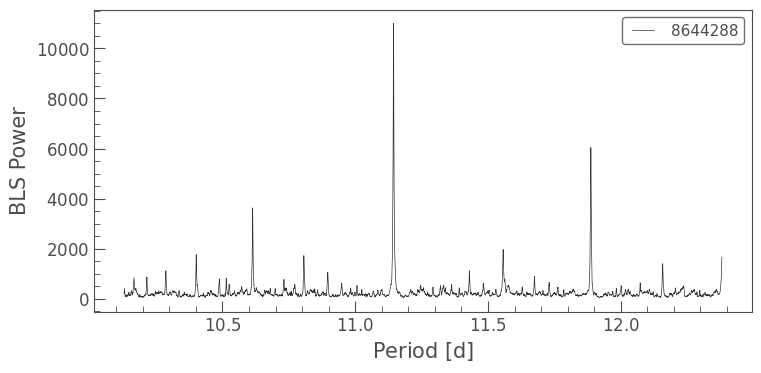

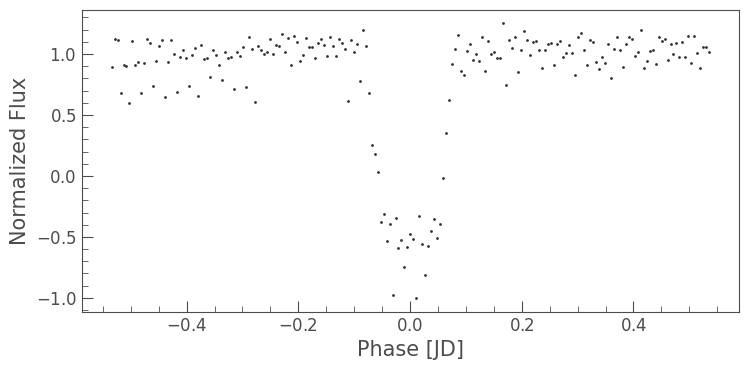

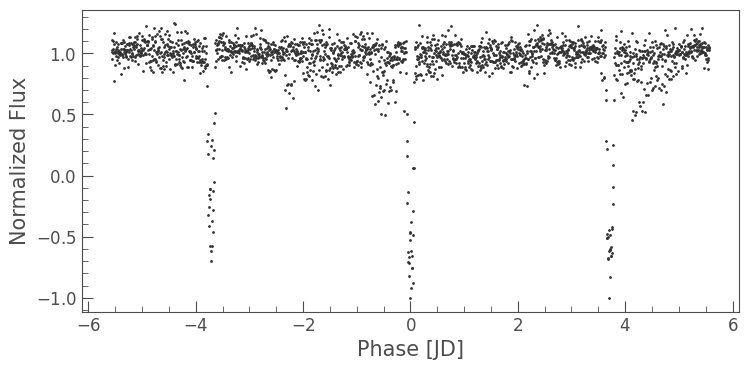

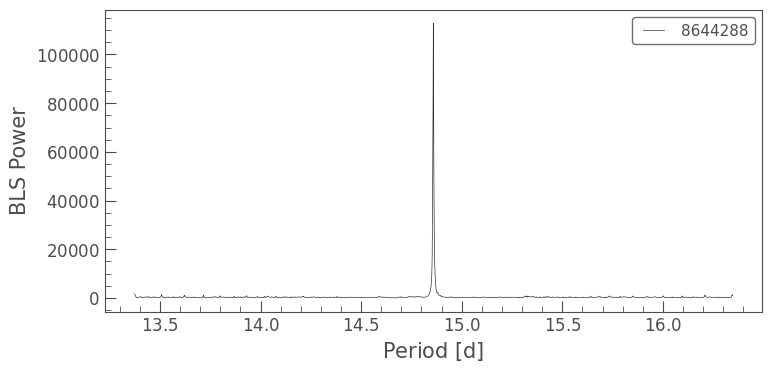

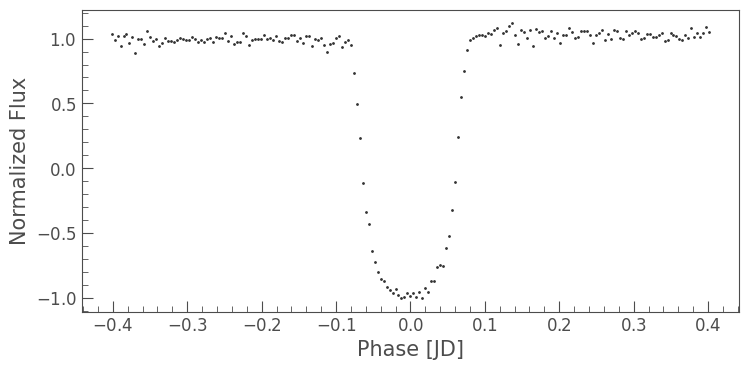

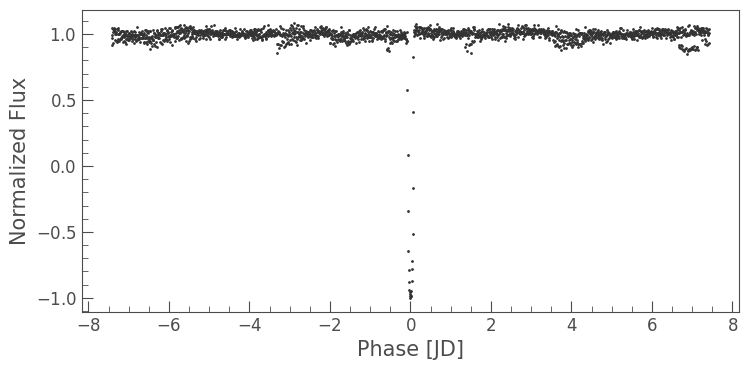

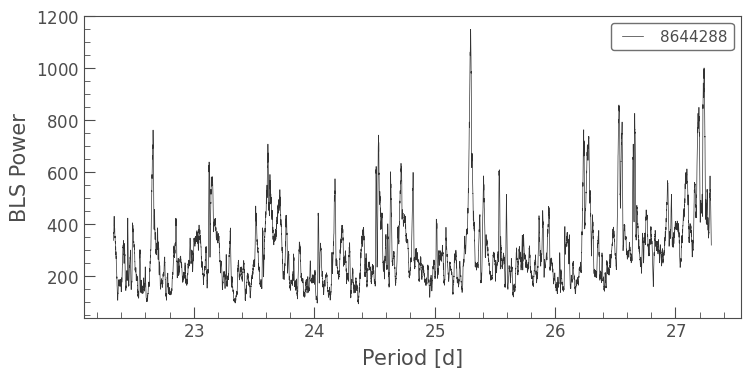

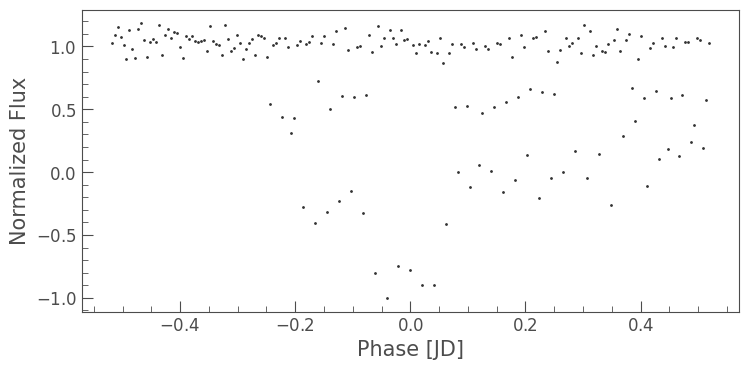

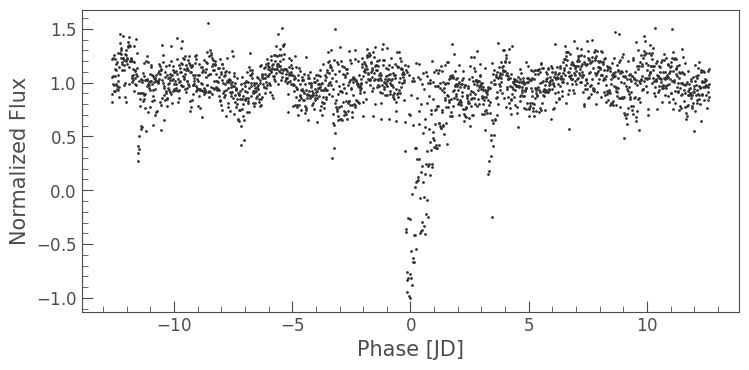

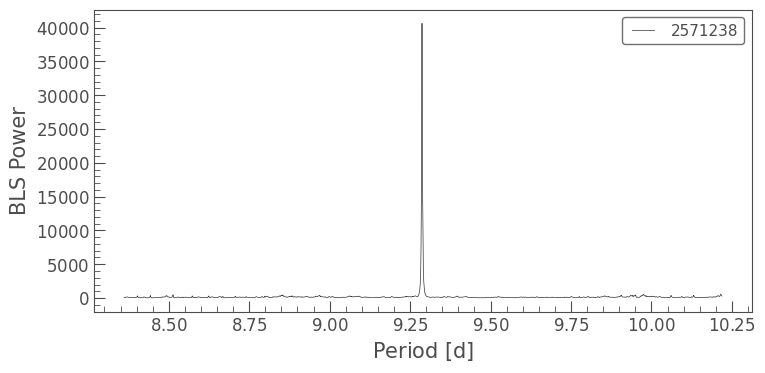

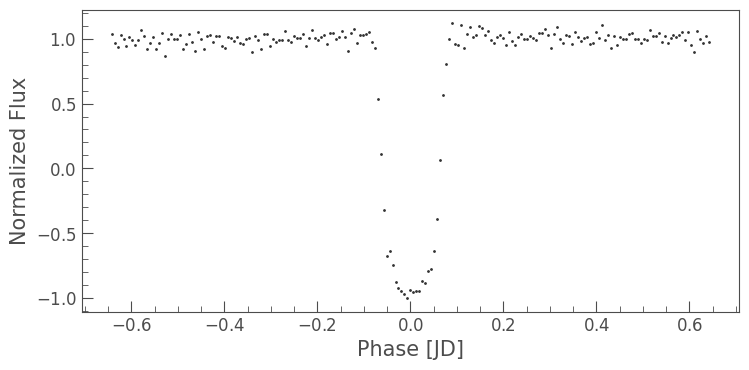

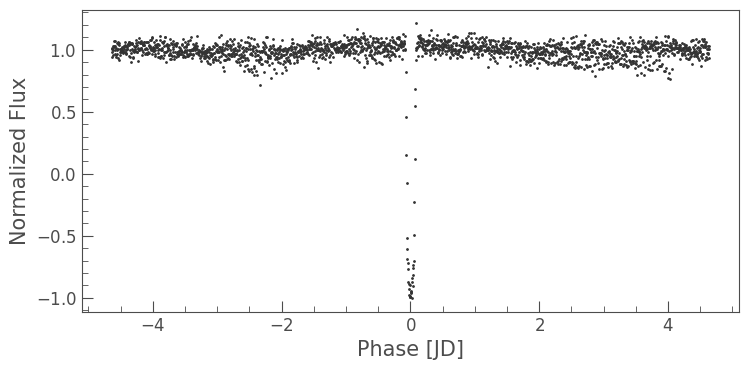

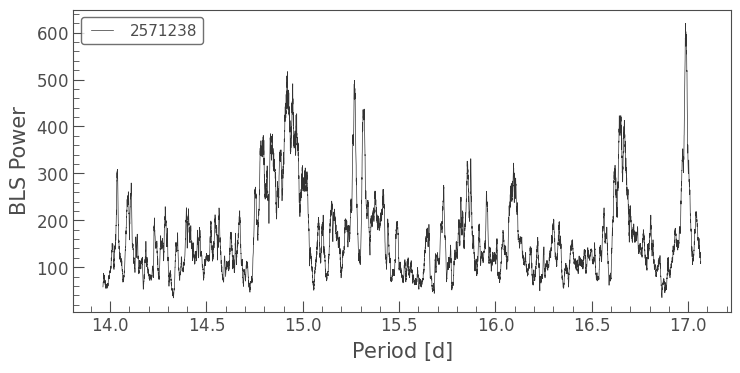

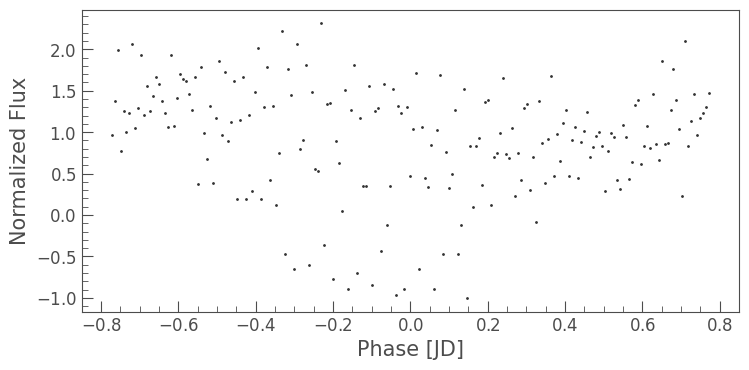

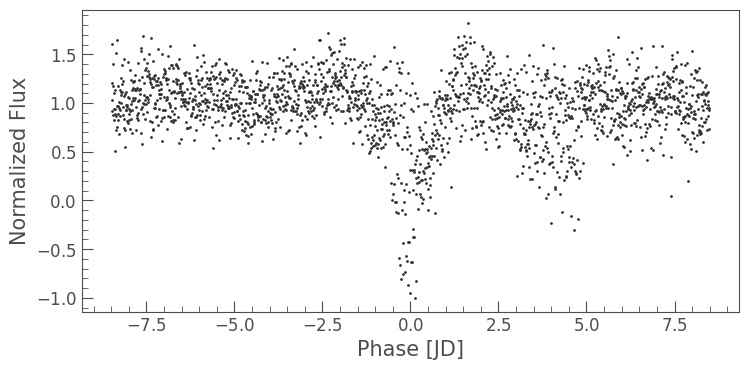

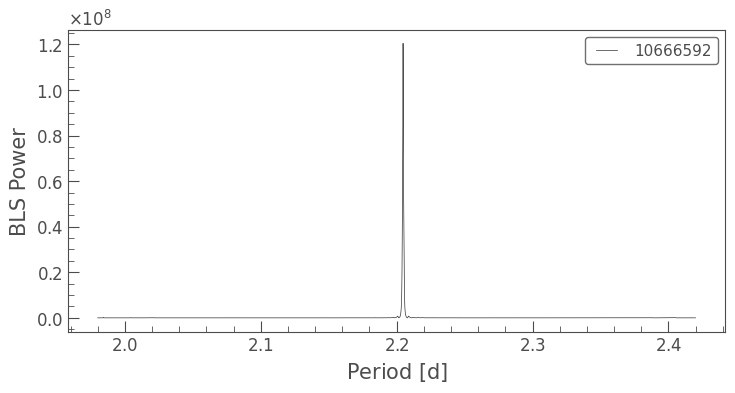

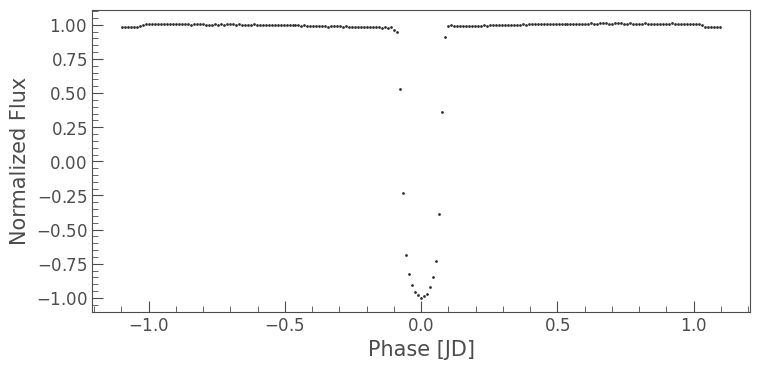

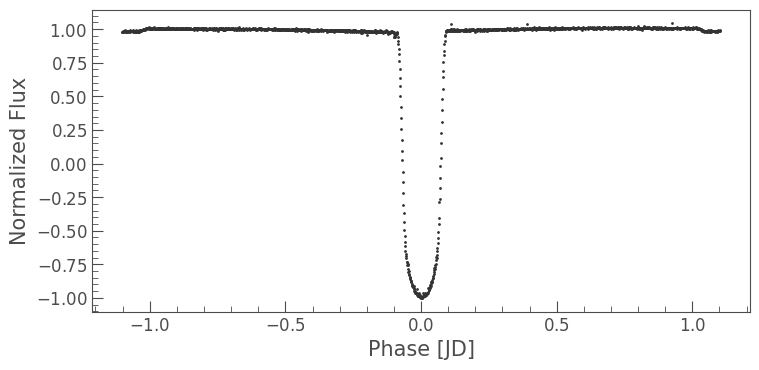

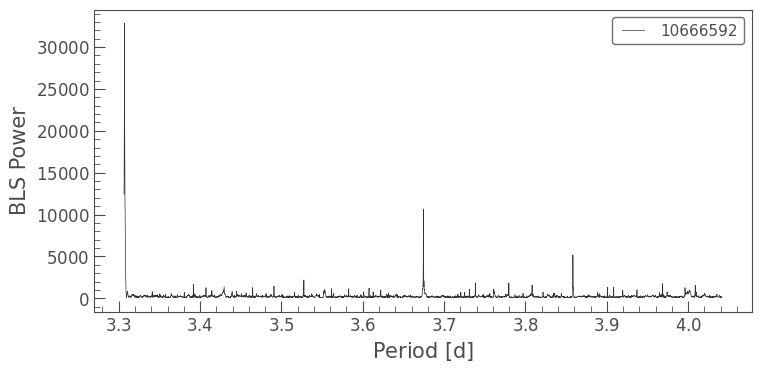

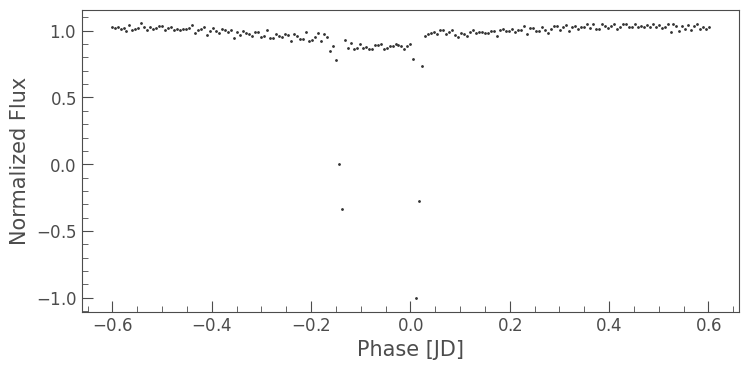

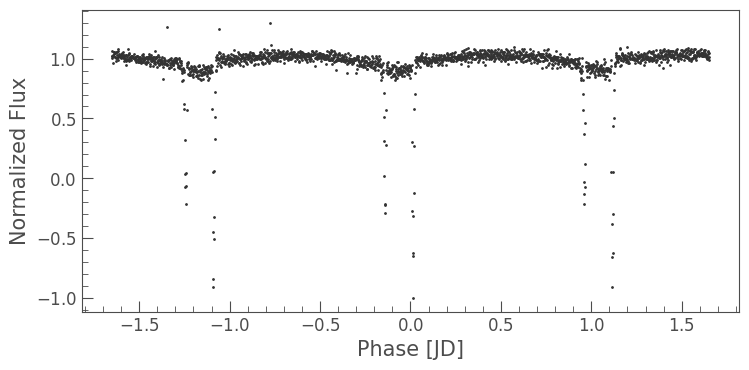

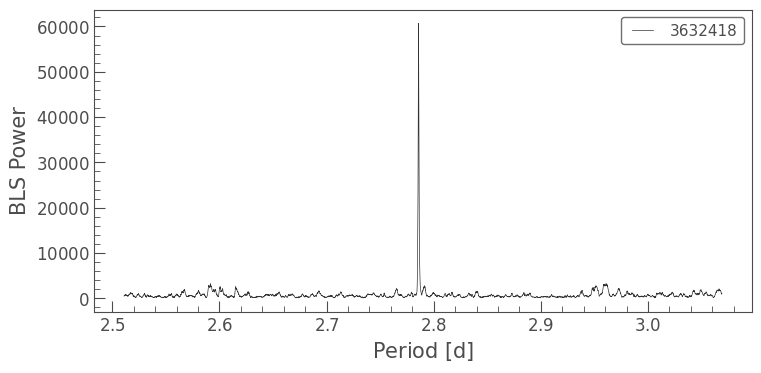

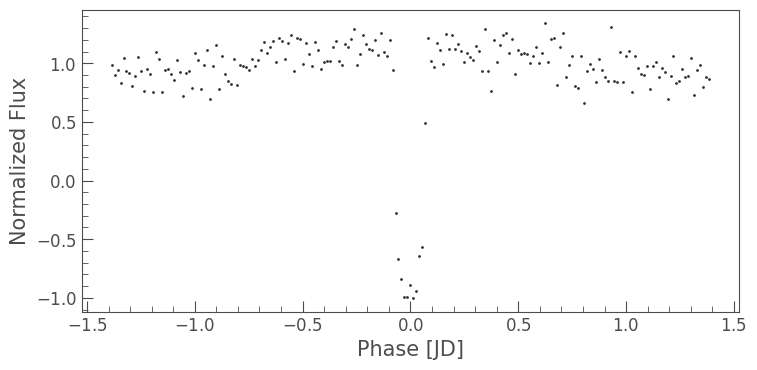

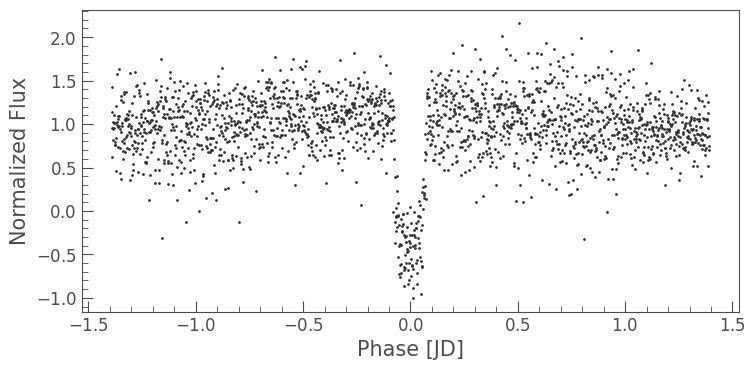

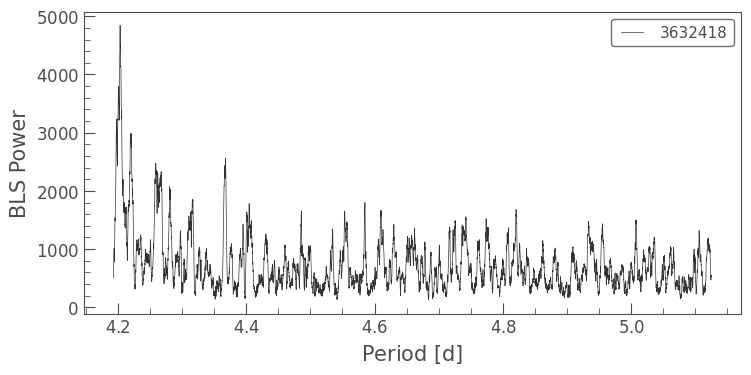

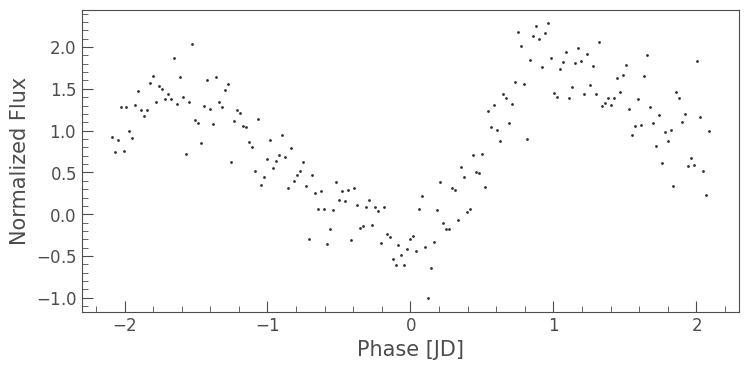

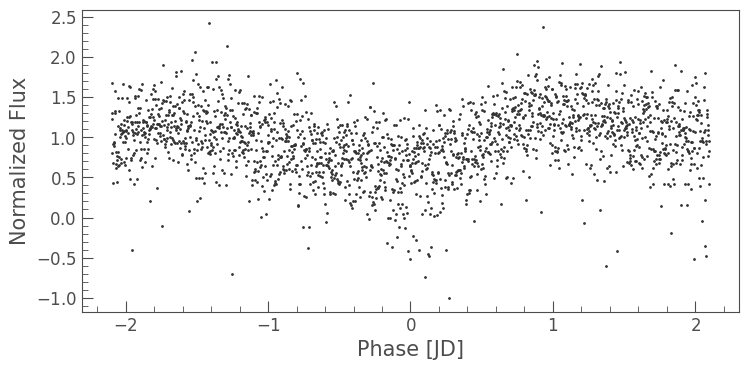

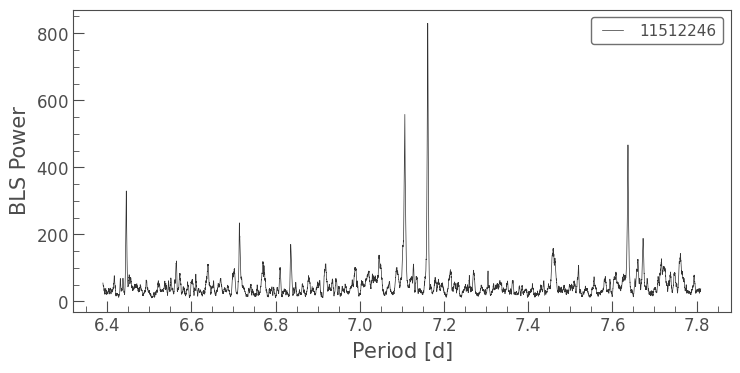

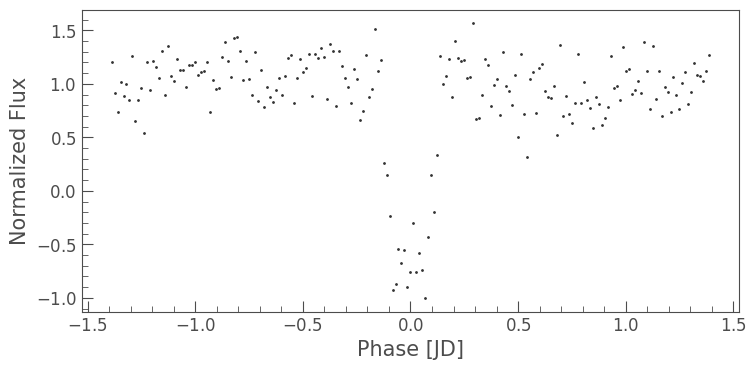

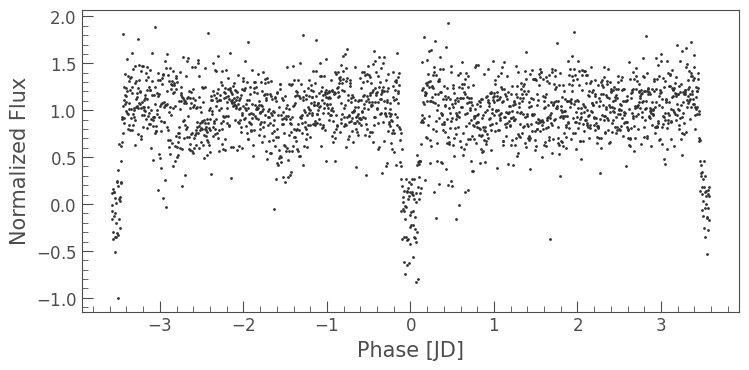

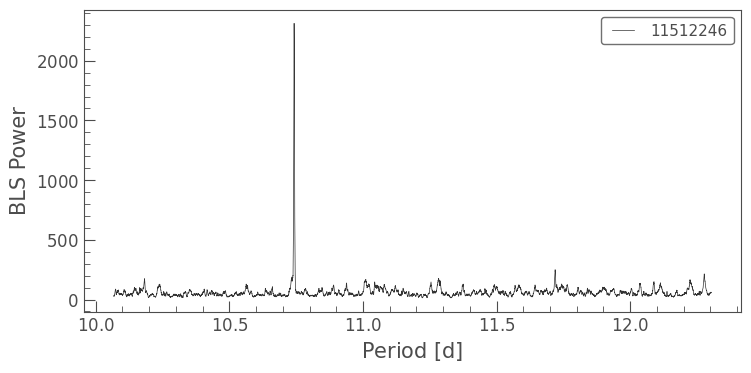

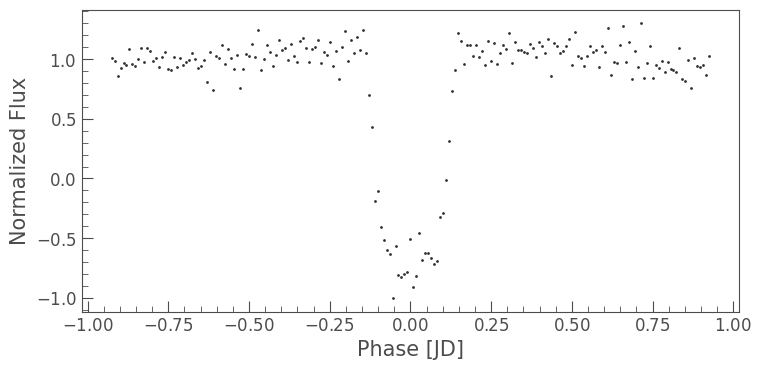

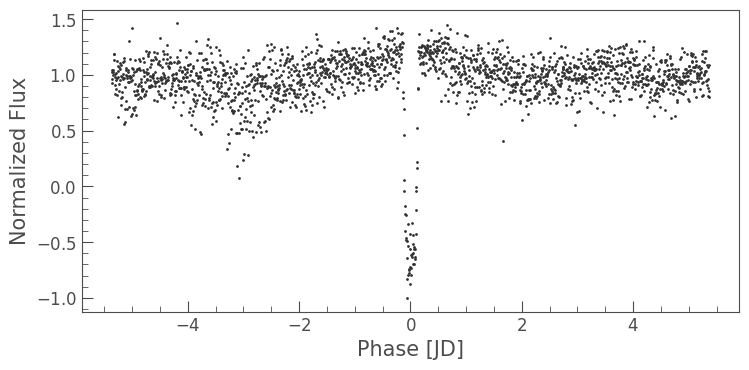

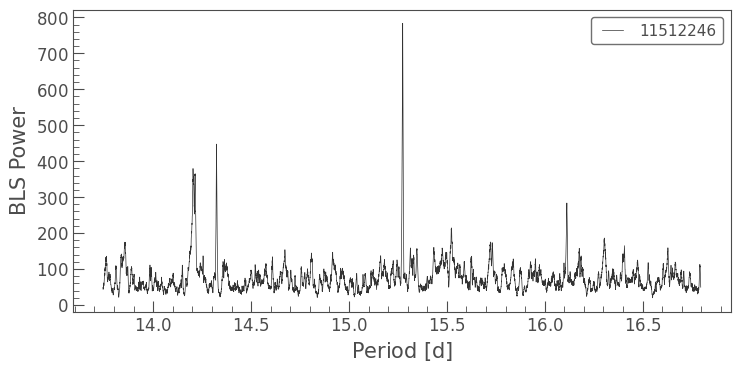

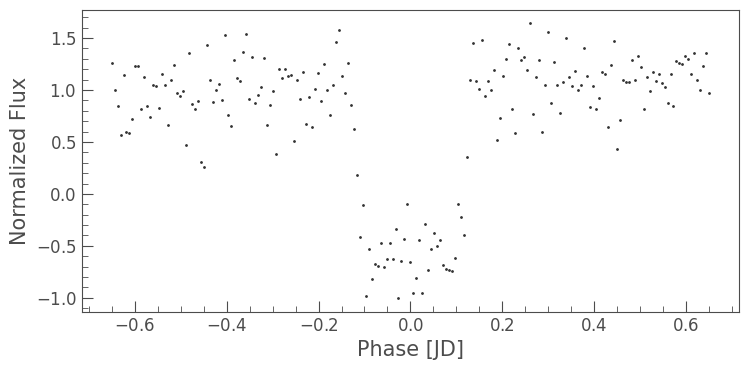

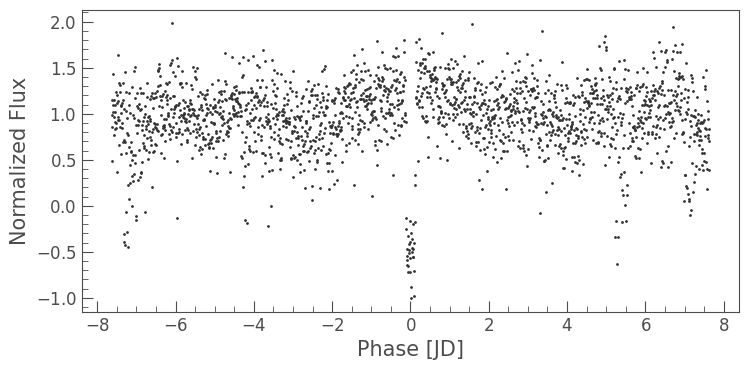

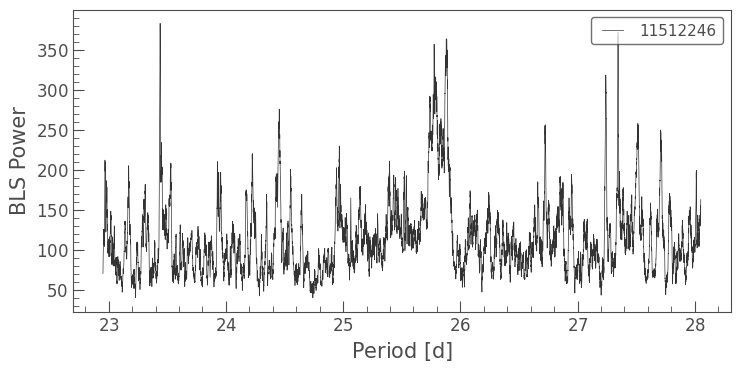

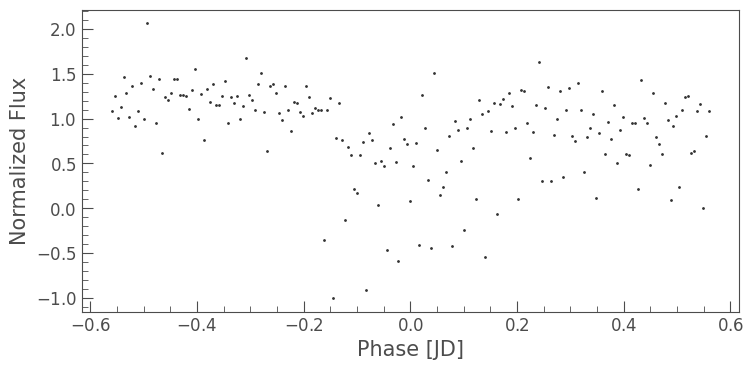

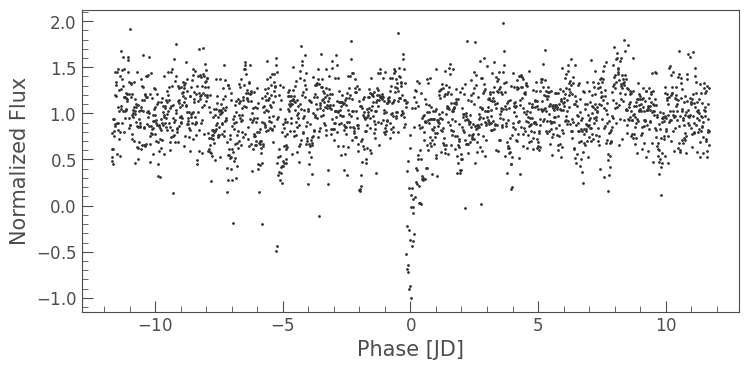

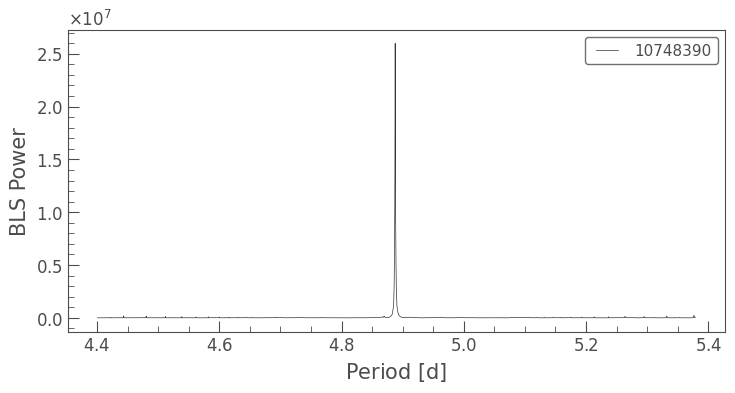

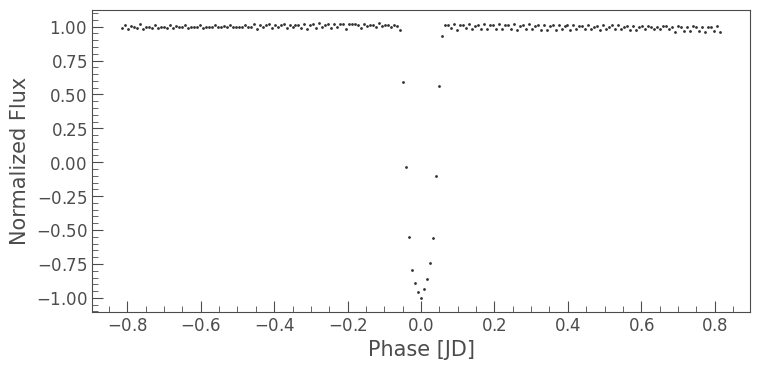

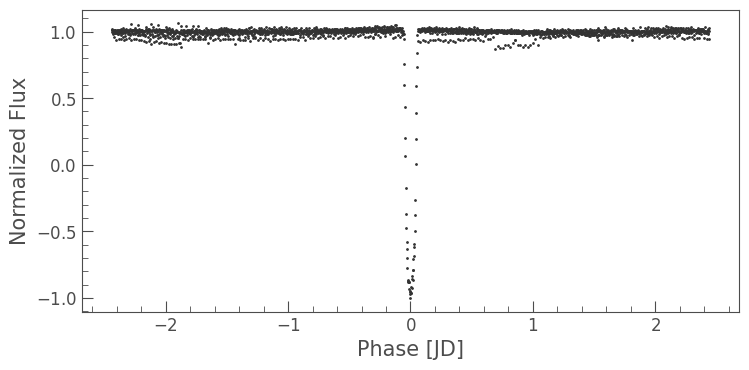

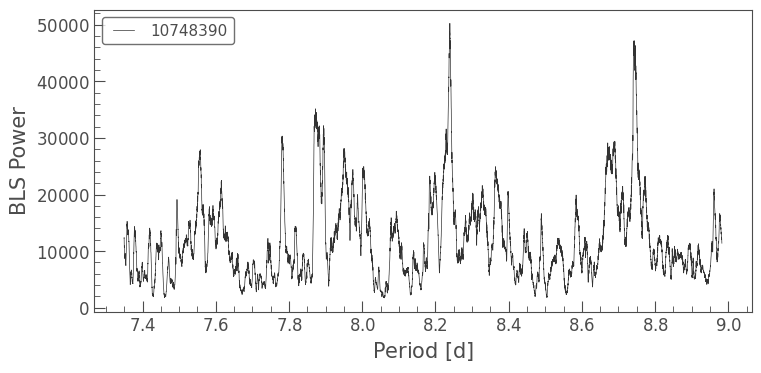

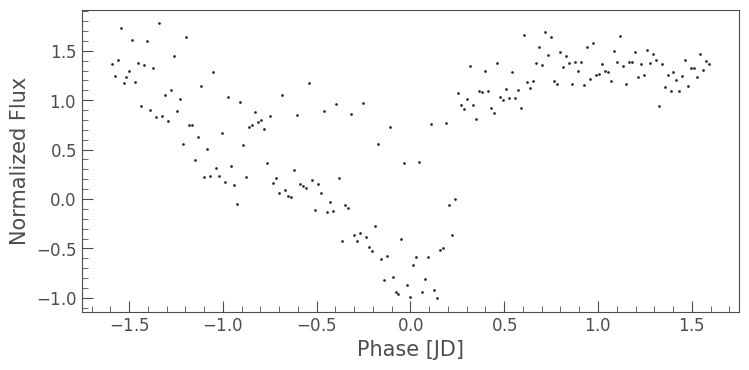

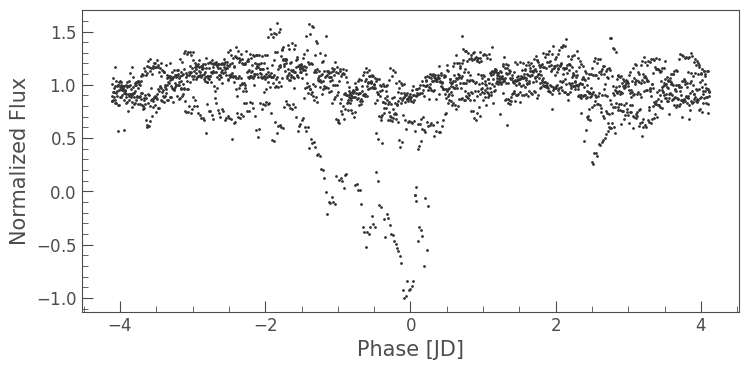

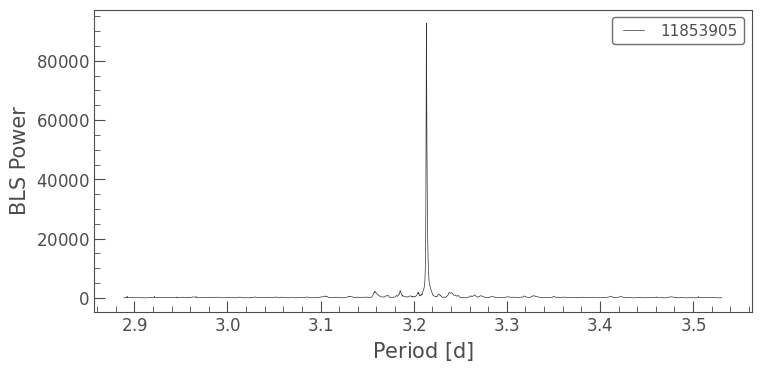

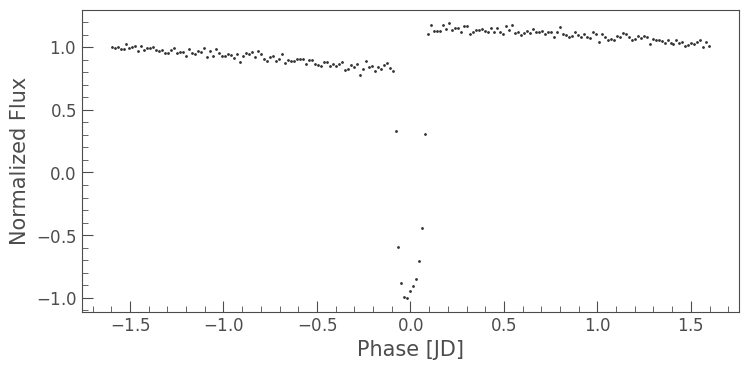

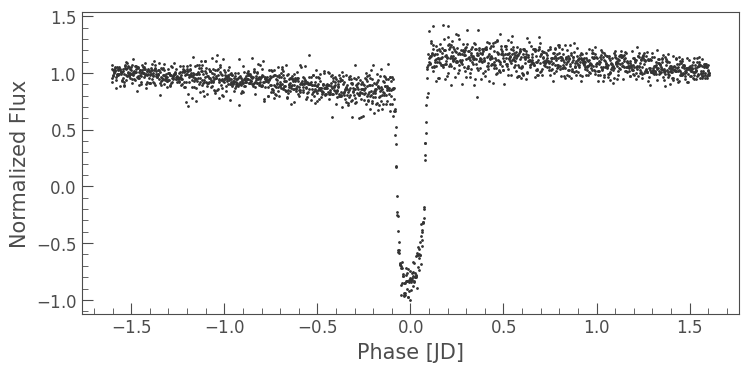

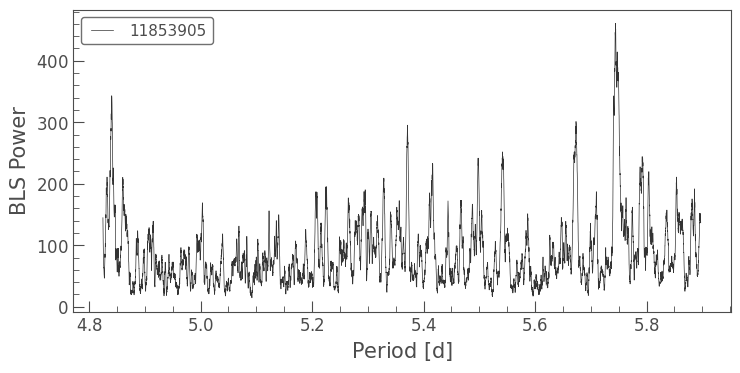

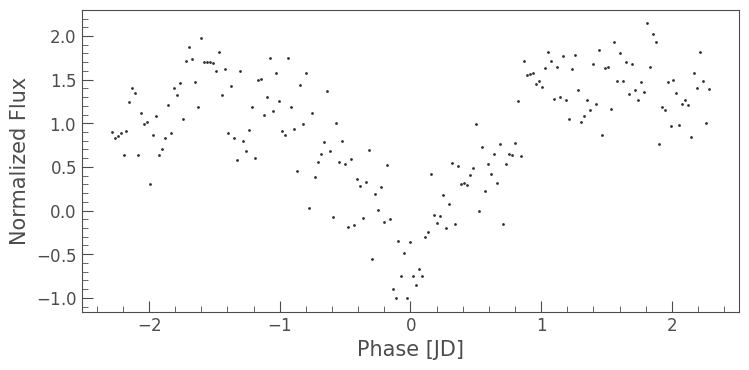

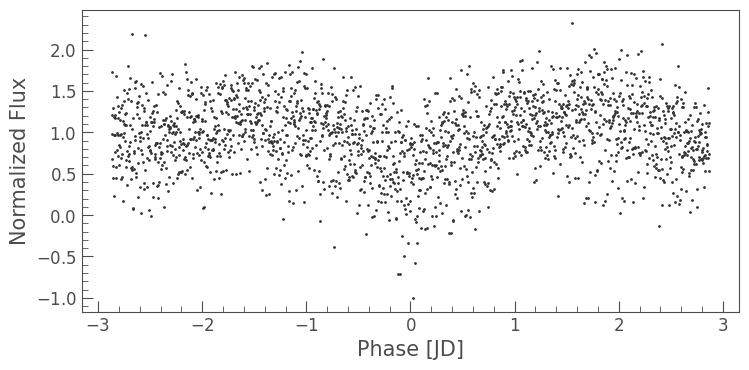

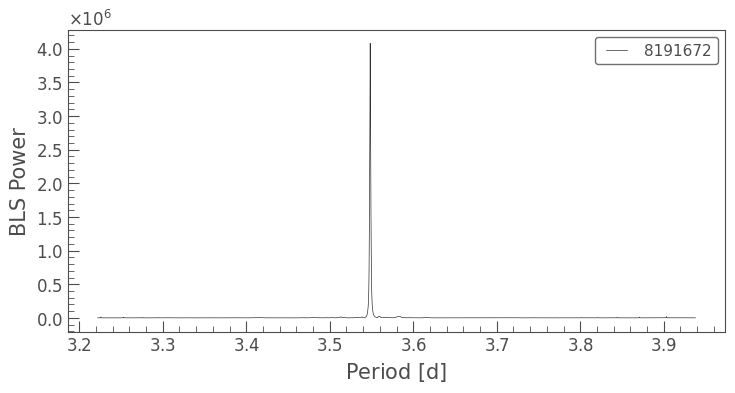

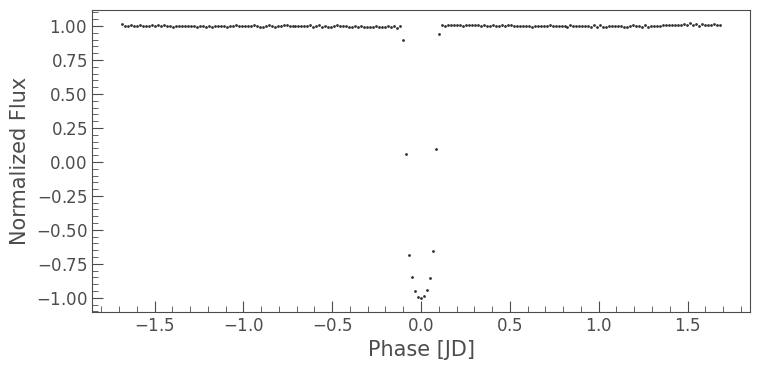

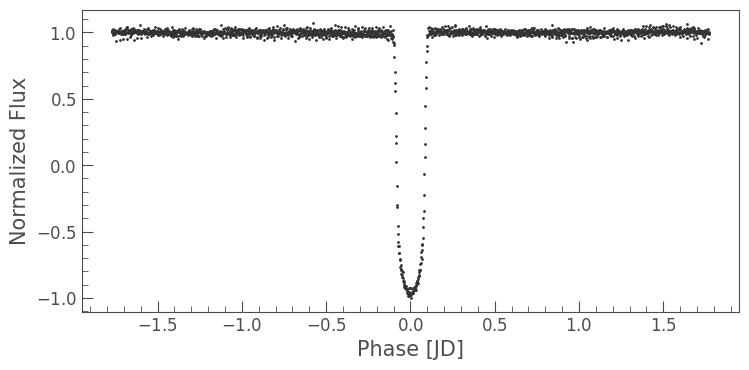

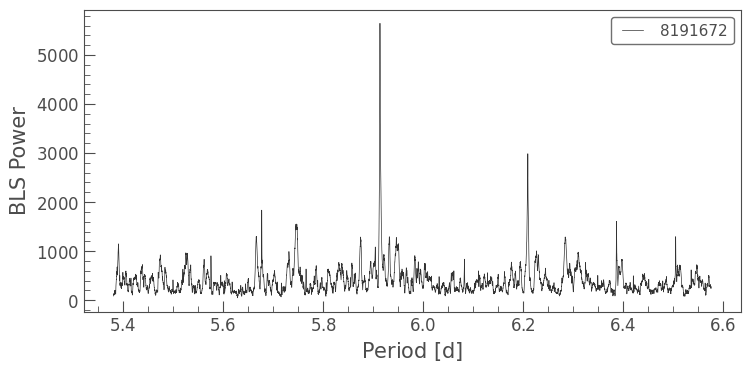

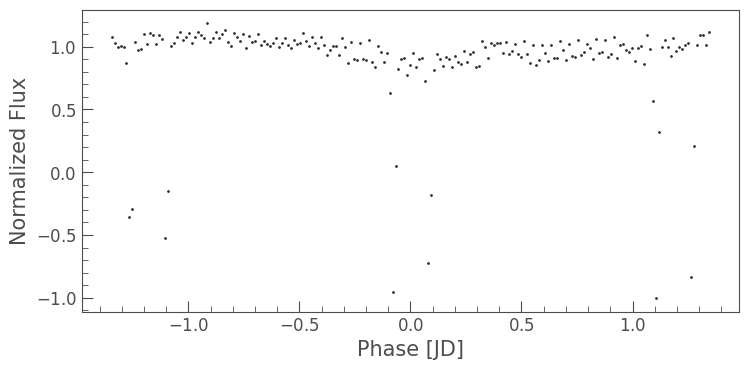

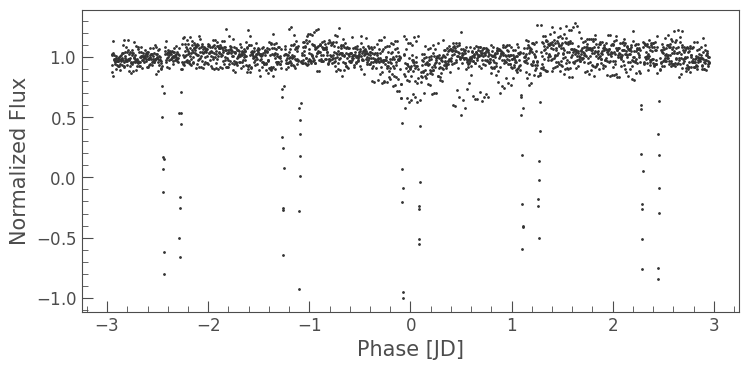

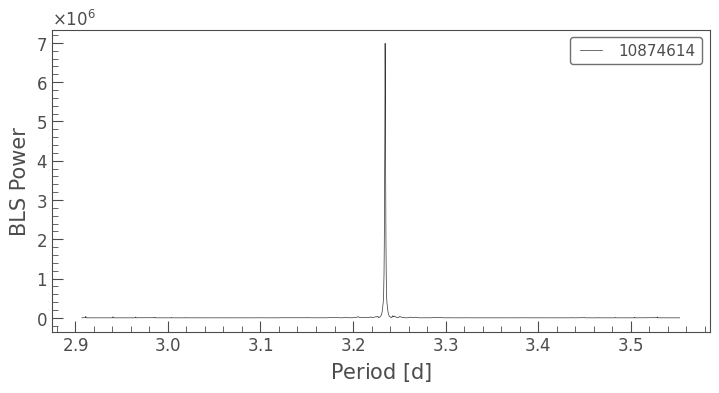

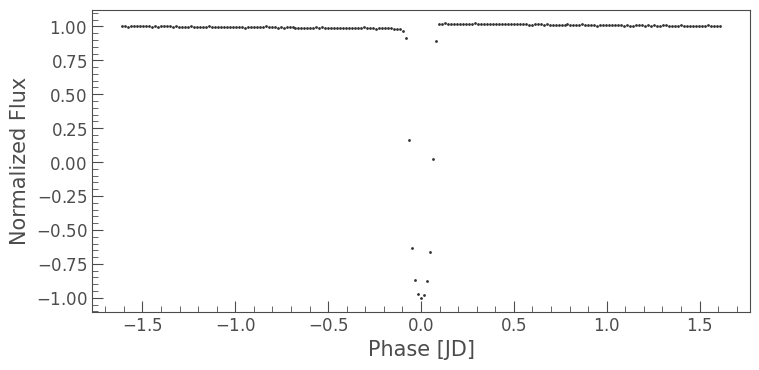

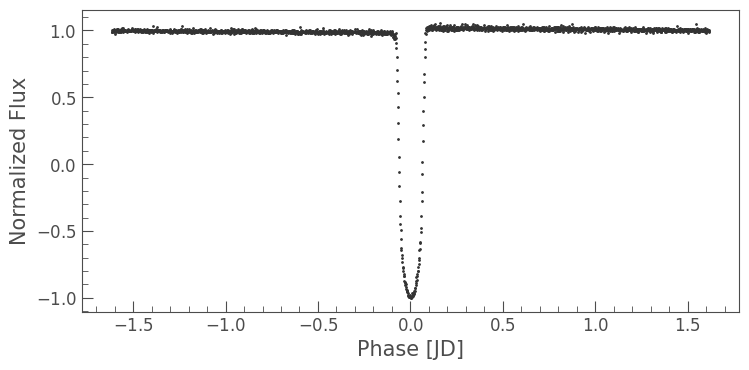

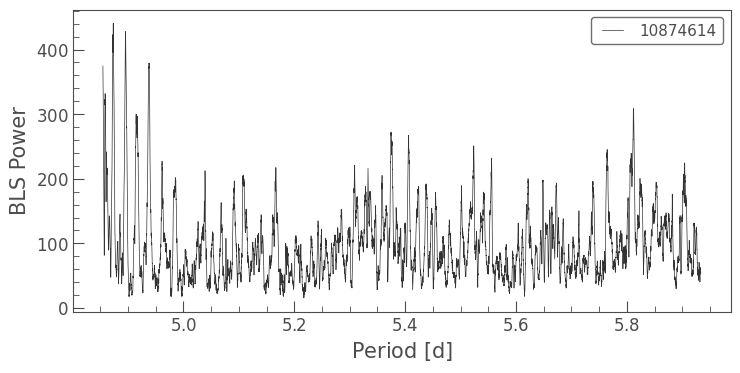

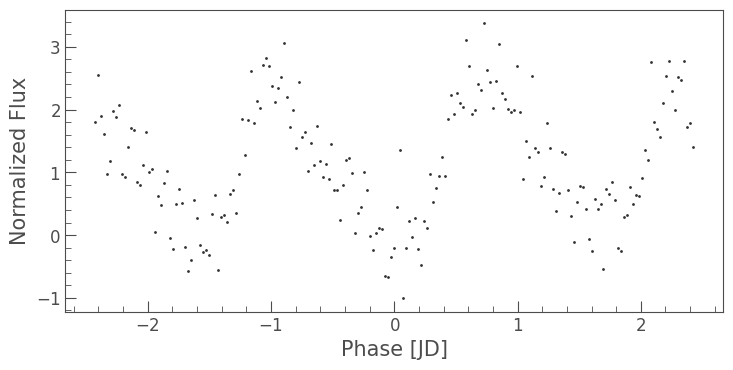

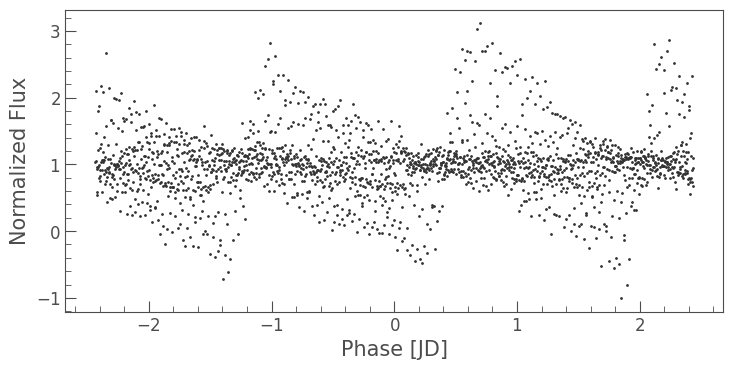

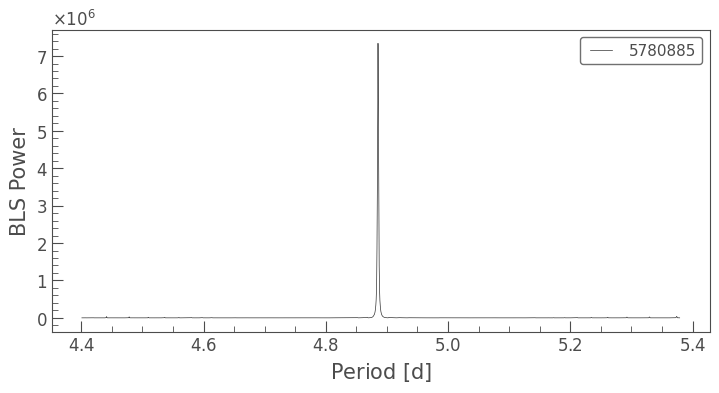

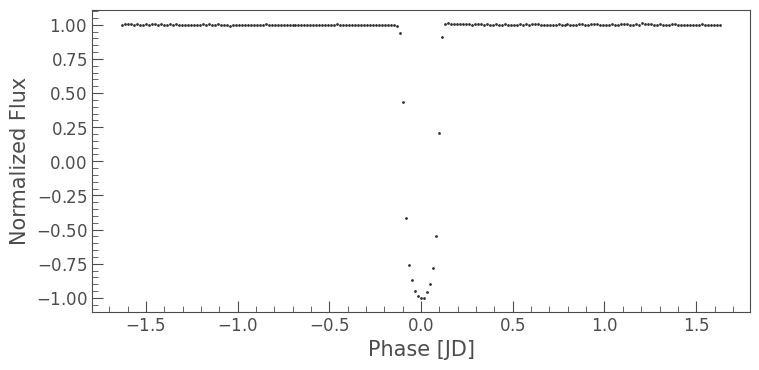

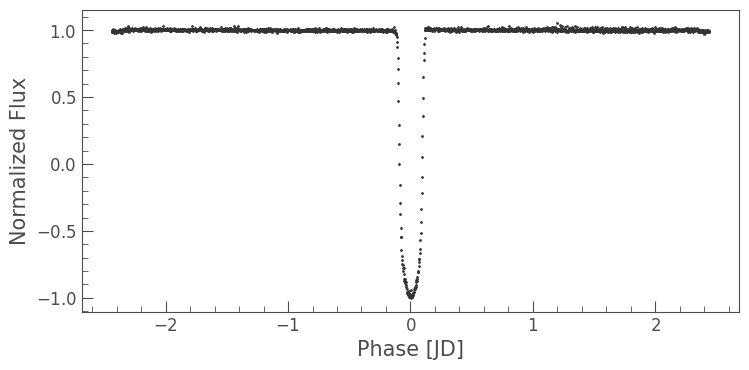

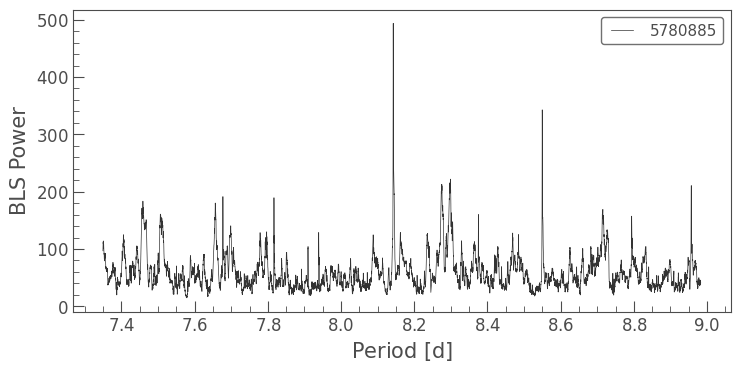

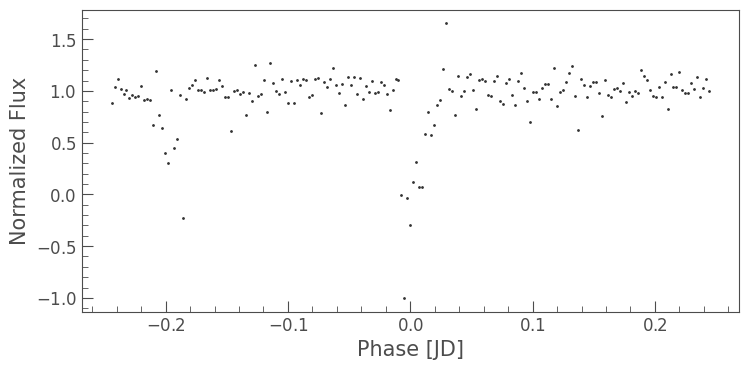

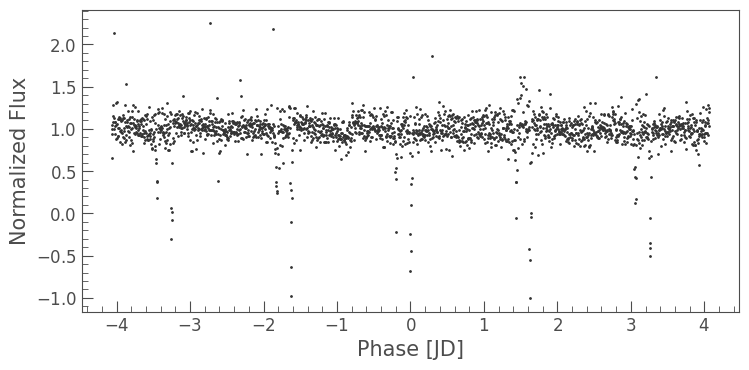

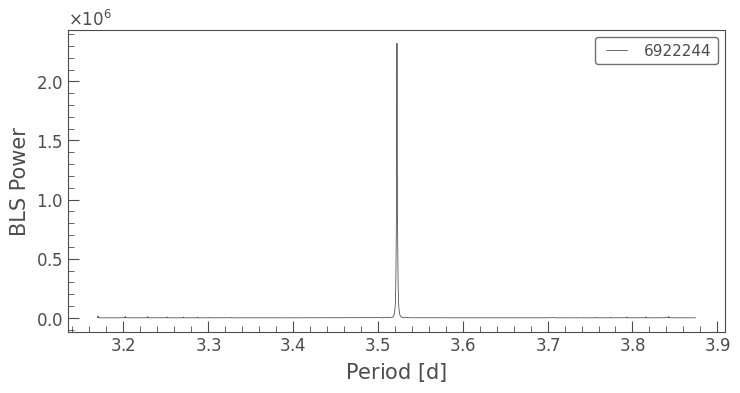

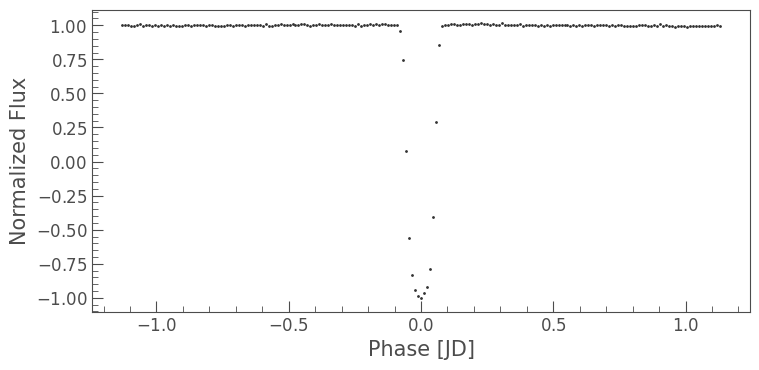

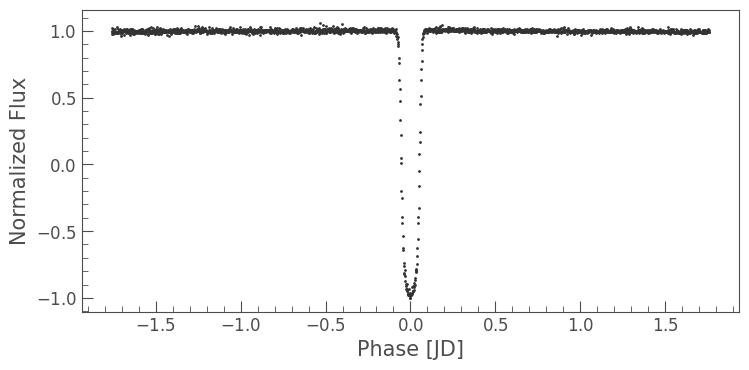

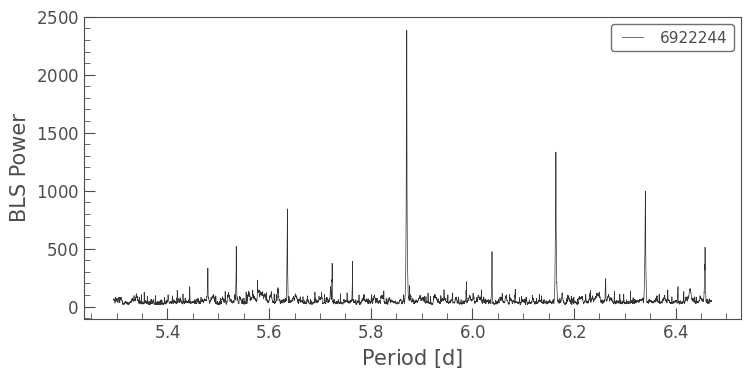

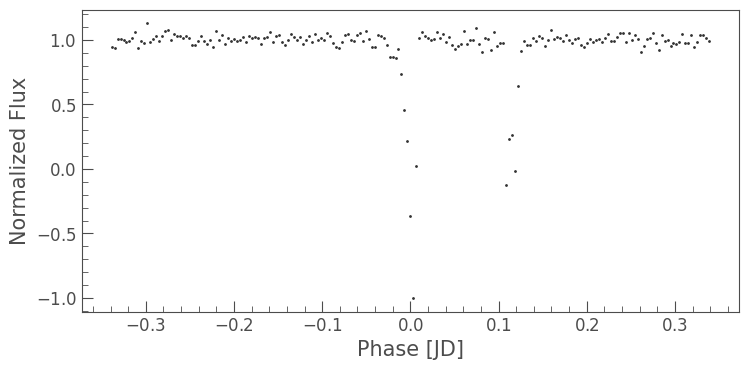

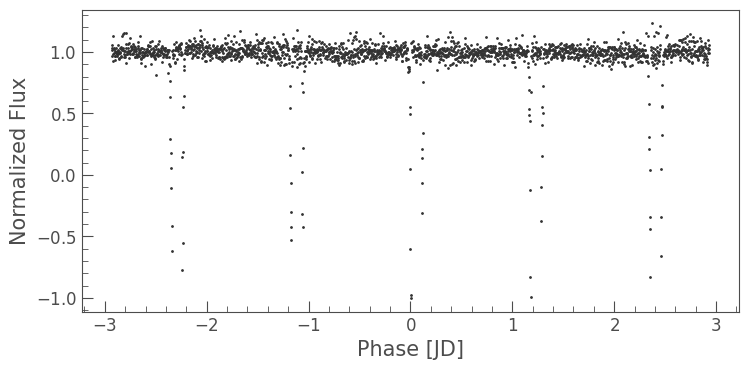

In [328]:
lv_input, gv_input, output = [], [], []

for item in grouped:
    lc = lcs[item["host"]]

    for period in item["periods"]:
        per = period["period"]
        pdg = lc.to_periodogram("bls", period=np.linspace(max(0.5, per * 0.9), per * 1.1, 10000))
        pdg.plot()
        per, dur, t0 = pdg.period_at_max_power, pdg.duration_at_max_power, pdg.transit_time_at_max_power
        fold = lc.fold(per, t0)

        gv = fold.bin(bins=2001)

        if np.isnan(gv.flux.value).any():
            gv.flux.value[np.isnan(gv.flux.value)] = np.nanmin(gv.flux.value)
    
        gv = gv.normalize() - 1
        gv = (gv / np.abs(np.nanmin(gv.flux))) * 2.0 + 1
        
        fractional_duration = dur / per
        width = 40
        phase_mask = (fold.phase.value > -width * fractional_duration) & (fold.phase.value < width * fractional_duration)
        lc_zoom = fold[phase_mask]
        lv = lc_zoom.bin(bins=201)

        if np.isnan(lv.flux.value).any():
            lv.flux.value[np.isnan(lv.flux.value)] = np.nanmin(lv.flux.value)
    
        lv = lv.normalize() - 1
        lv = (lv / np.abs(np.nanmin(lv.flux))) * 2.0 + 1

        lv_input.append(lv.flux.value)
        gv_input.append(gv.flux.value)

        out = [period["planet"]]
        output.append(out)

        if period["planet"]:
            mask = pdg.get_transit_mask(period=per, transit_time=t0, duration=dur)
            lc = lc[~mask]

        lv.scatter()
        gv.scatter()

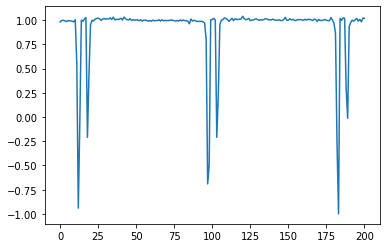

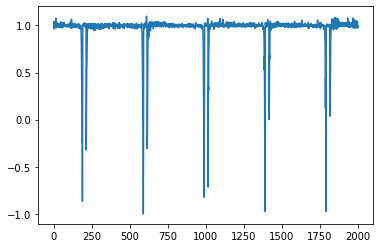

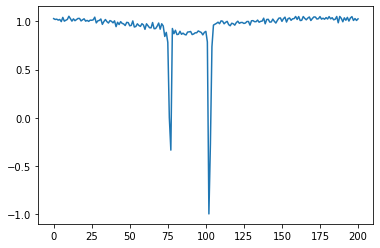

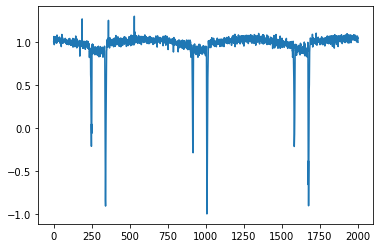

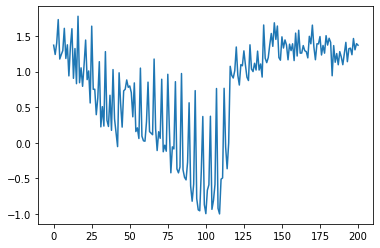

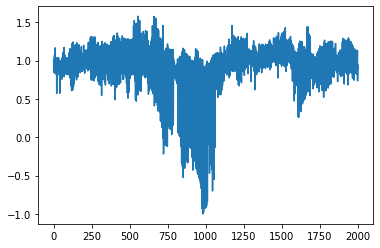

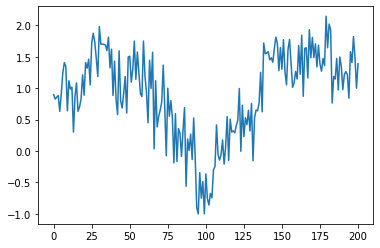

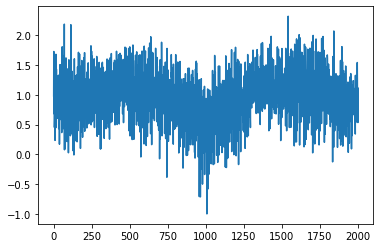

In [316]:
i = 0

import matplotlib.pyplot as plt

for i in range(len(lv_input)):
    if output[i] == [0]:
        plt.figure()
        plt.plot(lv_input[i])
        plt.figure()
        plt.plot(gv_input[i])
#output = np.argmax(output, axis=1)

# Neuronová sítě
## Formát vstupních dat

In [350]:
lv, gv, tg = np.array(lv_input), np.array(gv_input), np.array(output)

lv = lv.reshape((*lv.shape, 1))
gv = gv.reshape((*gv.shape, 1))
#tg = tg.reshape((*tg.shape, 1))

n_lv, *lv_shape = lv.shape
n_gv, *gv_shape = gv.shape
n_targets, *target_shape = tg.shape

lv_shape, gv_shape, target_shape

([201, 1], [2001, 1], [1])

## Architektura

In [351]:
# LV branch.
lv_inp = Input(lv_shape)
lv_branch = Conv1D(16, (3), activation="relu")(lv_inp)
lv_branch = MaxPool1D()(lv_branch)
lv_branch = Conv1D(32, (3), activation="relu")(lv_branch)
lv_branch = MaxPool1D()(lv_branch)
lv_branch = Conv1D(64, (3), activation="relu")(lv_branch)
lv_branch = MaxPool1D()(lv_branch)
lv_branch = Flatten()(lv_branch)
lv_branch = Model(lv_inp, lv_branch)

# GV branch.
gv_inp = Input(gv_shape)
gv_branch = Conv1D(16, (3), activation="relu")(gv_inp)
gv_branch = MaxPool1D()(gv_branch)
gv_branch = Conv1D(32, (3), activation="relu")(gv_branch)
gv_branch = MaxPool1D()(gv_branch)
gv_branch = Conv1D(64, (3), activation="relu")(gv_branch)
gv_branch = MaxPool1D()(gv_branch)
gv_branch = Flatten()(gv_branch)
gv_branch = Model(gv_inp, gv_branch)

# Main branch.
main_branch = Concatenate()([lv_branch.output, gv_branch.output])
main_branch = Dense(128, activation="tanh")(main_branch)
main_branch = Dense(128, activation="tanh")(main_branch)
main_branch = Dense(1, activation="tanh")(main_branch)
model = Model([lv_branch.input, gv_branch.input], main_branch)

model.compile(optimizer=RMSprop(), loss="mse")

model.summary()

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_72 (Conv1D)              (None, 199, 16)      64          input_25[0][0]                   
__________________________________________________________________________________________________
conv1d_75 (Conv1D)              (None, 1999, 16)     64          input_26[0][0]                   
___________________________________________________________________________________________

## Trénovací a testovací množina

In [357]:
def shuffle(*args, seed=None):
    i = np.arange(args[0].shape[0])
    np.random.seed(seed)
    np.random.shuffle(i)
    return tuple(map(lambda x: x[i], args))

test_size = 10
lv, gv, tg = shuffle(lv, gv, tg)

train_gv, test_gv = gv[:-test_size + 1], gv[-test_size + 1:]
train_lv, test_lv = lv[:-test_size + 1], lv[-test_size + 1:]
train_tg, test_tg = tg[:-test_size + 1], tg[-test_size + 1:]

#train_gv, test_gv = gv[:], gv[:]
#train_lv, test_lv = lv[:], lv[:]
#train_tg, test_tg = tg[:], tg[:]

lv.shape, gv.shape, tg.shape
train_lv.shape, test_lv.shape, train_gv.shape, train_lv.shape

((35, 201, 1), (9, 201, 1), (35, 2001, 1), (35, 201, 1))

## Trénování

In [355]:
callback = EarlyStopping(monitor="loss", patience=50)
model.fit([train_lv, train_gv], train_tg, epochs=10000, validation_split=0.15, callbacks=[callback])

Epoch 1/10000
1/1 [==============================] - 0s 241ms/step - loss: 0.5172 - val_loss: 0.5000
Epoch 2/10000
1/1 [==============================] - 0s 89ms/step - loss: 0.5172 - val_loss: 0.5000
Epoch 3/10000
1/1 [==============================] - 0s 95ms/step - loss: 0.5172 - val_loss: 0.5000
Epoch 4/10000
1/1 [==============================] - 0s 97ms/step - loss: 0.5172 - val_loss: 0.5000
Epoch 5/10000
1/1 [==============================] - 0s 96ms/step - loss: 0.5172 - val_loss: 0.5000
Epoch 6/10000
1/1 [==============================] - 0s 102ms/step - loss: 0.5172 - val_loss: 0.5000
Epoch 7/10000
1/1 [==============================] - 0s 103ms/step - loss: 0.5172 - val_loss: 0.5000
Epoch 8/10000
1/1 [==============================] - 0s 97ms/step - loss: 0.5172 - val_loss: 0.5000
Epoch 9/10000
1/1 [==============================] - 0s 104ms/step - loss: 0.5172 - val_loss: 0.5000
Epoch 10/10000
1/1 [==============================] - 0s 97ms/step - loss: 0.5172 - val_loss: 0.

## Testování

In [356]:
results = np.abs(np.round(model.predict([test_lv, test_gv])))
errors = (results != test_tg).sum()
percentage = 100 - 100 * np.round(errors / len(test_lv), 2)

f"Errors: {errors} (success rate: {percentage} %)"

'Errors: 2 (success rate: 78.0 %)'